<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #1: Perceptrones Multicapa o Redes FF </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

In [306]:
import numpy as np
import matplotlib.pyplot as plt

# sklearn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split

# keras functionalities
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

## Table de Contenidos
* [El XOR](#xor)
    * [Parte (a)](#1a)
    * [Parte (b)](#1b)
    * [Parte (c)](#1c)
* [Predicción del precio de una casa](#pred)
    * [Parte (a)](#2a)
    * [Parte (b)](#2b)
    * [Parte (c)](#2c)
    * [Parte (d)](#2d)
    * [Parte (e)](#2e)
    * [Parte (f)](#2f)
    * [Parte (g)](#2g)
    * [Parte (h)](#2h)
    * [Parte (i)](#2i)
    * [Parte (j)](#2j)
* [Reconocimiento de imágenes en CIFAR10](#rec)


<div id='xor' />
## 1.-  El XOR

<div id='1a' />
### Parte (a)

La función `xor_generator(m)` que se muestra a continuación genera $m$ datos aleatorios con la distribución que asemeja el comportamiento de XOR. La estrategia seguida fue generar puntos aleatorios en la región $[-1,1] \times [-1,1]$, etiquetando a los puntos de los cuadrantes I y III con $0$, y a los puntos de los cuadrantes II y IV con $1$. 

Adicionalmente, para cada cuadrante se realizó una _transformación lineal_ para alejar a los puntos de los ejes. Lo último es debido a que de otra manera, cuando existen puntos de distinta clase muy cercanos entre sí (en un eje), el problema se vuelve más complejo.

**Observación**: Esta distribución de puntos se dice simular XOR, pues simula el comportamiento de operador lógico _exclusive or_. Cuando dos puntos tienen coordenada $(x,y)$ de distintas signo se dice que pertenecen a la clase $1$, y cuando las coordenadas $(x,y)$ tienen mismo signo, pertenecen a la clase $0$.

In [356]:
# for reproducibility of experiments
np.random.seed(1)

def xor_generator(m):
    """
    m: number of points to generate
    """
    # generate m random points on [-1,1]x[-1,1]
    X = 2.*np.random.random(m)-1.
    Y = 2.*np.random.random(m)-1. 
    
    # arrangement to cluster the points
    x_mask = X>0.
    y_mask = Y>0.
    X[x_mask] *= 0.8; X[x_mask] += 0.1
    X[~x_mask] *= 0.8; X[~x_mask] -= 0.1
    Y[y_mask] *= 0.8; Y[y_mask] += 0.1
    Y[~y_mask] *= 0.8; Y[~y_mask] -= 0.1    
    XY = np.vstack([X,Y]).T
    
    # generating the labels
    y = np.zeros(m, dtype=np.int)
    mask = np.multiply.reduce(XY, axis=1) > 0.
    y[mask] = 1
    return (XY, y)

def xor_plot(X,y):
    X0 = X[y==0]
    X1 = X[y==1]
    plt.figure(figsize=(7,7))
    plt.scatter(X0[:,0], X0[:,1], c='b')
    plt.scatter(X1[:,0], X1[:,1], c='r')
    plt.plot((-1.1,1.1),(0,0),'k--')
    plt.plot((0,0),(-1.1,1.1),'k--')
    plt.xlim([-1.1,1.1])
    plt.ylim([-1.1,1.1])
    plt.show()

Se generan a continuación 2000 datos aleatorios, mostrando su distribución gráficamente.

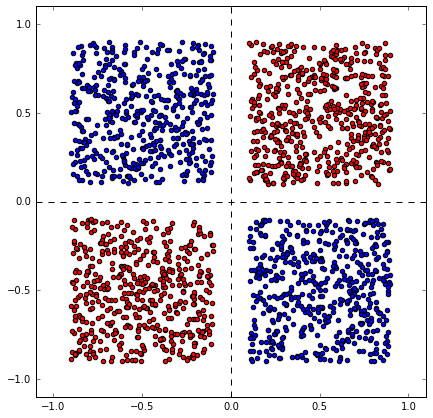

In [357]:
X,y = xor_generator(2000)
xor_plot(X,y)

A continuación se generan los conjuntos de entrenamiento, validación y prueba. De los 2000 datos generados, 1000 son de entrenamiento y 1000 de prueba. Sin embargo de los 1000 de entrenamiento, 20% se ha dejado para la validación durante el entrenamiento de la red.  

**Nota**: Dado que los datos se generaron aleatoriamente, se ha omitido particionar estos conjuntos de forma aleatoria y se ha realizado de forma secuencial.

In [358]:
# training data
X_tr = X[0:800]
y_tr = y[0:800]

# validation data
X_val = X[800:1000]
y_val = y[800:1000]

# testing data
X_ts = X[1000::]
y_ts = y[1000::]

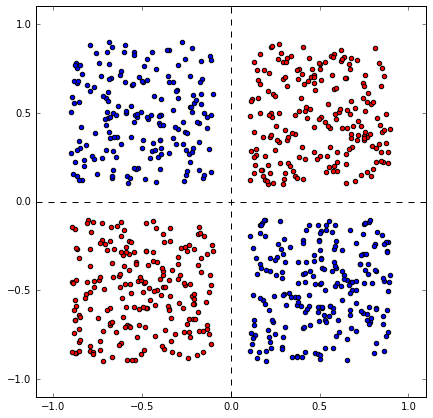

In [359]:
# training data
xor_plot(X_tr, y_tr)

<div id='1b' />
### Parte (b)

En esta primera parte se ha construido una red consistente de una única neurona con las siguientes características:
* Inicialización de pesos distribuida normal.
* Función de activación sigmoidal. Dado que la salida está entre 0 y 1, `keras` utiliza este valor para determinar la correspondiente clase.
* Algoritmo de entrenamiento: [`ADAM`](http://arxiv.org/abs/1412.6980v8). Este es un eficiente y robusto algoritmo estocástico, basado en estimaciones de bajo orden para el momentum. Fue elegido para asegurar la convergencia.  
* _Cross-Entropy_ binaria como función de pérdida: $L(y, \tilde{y}) = - \tilde{y}\log(y) - (1-\tilde{y})\log(1-y)$ ($\tilde{y}$ predicción de $y$). Esto pues esta función de pérdida es una elección estandar para problemas de clasificación binária.
* Número de épocas: 300. 

In [399]:
# building the model
model0 = Sequential()
model0.add(Dense(output_dim=1, input_dim=2, activation='sigmoid', init='normal'))
# compiling the model
model0.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitting the model
hist0 = model0.fit(X_tr, y_tr, nb_epoch=300, verbose=0, validation_data=(X_val, y_val))

La performance obtenida sobre el conjunto de prueba se muestra a continuación:

In [400]:
scores = model0.evaluate(X_ts, y_ts, verbose=0)
print("\n{0}: {1}%".format('Accuracy', scores[1]*100))


Accuracy: 54.8%


Este resultado nos indíca que un simple neurona tiene un accuracy $\approx$50%, es decir, se comporta logra clasificar bien sólo la mitad de los datos (similar a un clasificador aleatorio). 

Con lo cual se prueba _experimentalmente_ que un sola neurona no resuelve el problema no lineal de XOR. Este es un resultado conocido, dado que, pese a que tiene una activación no lineal, la función de decisión sigue siendo lineal ($w^T x = 0$), y por lo tanto no es posible que logre clasificar data distribuida no linealmente. 

<div id='1c' />
### Parte (c)

Para esta parte se mantiene casi la misma configuración anterior, más unos pequeños ajustes:
* Se agrega una capa oculta con dos neuronas, ambas con función de activación `tanh`.
* Ambas capas tienen inicialización de pesos distribuida normal.

In [402]:
# building the model
model1 = Sequential()
model1.add(Dense(output_dim=2, input_dim=2, activation='tanh', init='normal'))
model1.add(Dense(output_dim=1, init='normal', activation='sigmoid'))
# compiling the model
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitting the model
hist1 = model1.fit(X_tr, y_tr, nb_epoch=300, verbose=0, validation_data=(X_val, y_val))

In [403]:
scores = model1.evaluate(X_ts, y_ts, verbose=0)
print("\n{0}: {1}%".format('Accuracy', scores[1]*100))


Accuracy: 91.4%


Como puede notarse el _accuracy_ sobre el conjunto de prueba aumento de manera notoria. Esto nos demuestra _experimentalmente_ que con tan solo agregar dos neuronas en una capa oculta, la red ahora es capaz de aprender fronteras de decisión no lineales. 

A continuación se entrena el mismo modelo anterior, pero con 10 neuronas en la capa oculta.

In [404]:
# building the model
model2 = Sequential()
model2.add(Dense(output_dim=10, input_dim=2, activation='tanh', init='normal'))
model2.add(Dense(output_dim=1, init='normal', activation='sigmoid'))
# compiling the model
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fitting the model
hist2 = model2.fit(X_tr, y_tr, nb_epoch=300, verbose=0, validation_data=(X_val, y_val))

In [405]:
scores = model2.evaluate(X_ts, y_ts, verbose=0)
print("\n{0}: {1}%".format('Accuracy', scores[1]*100))


Accuracy: 100.0%


El resultado es un ajuste perfecto sobre el test de prueba. Esto va acorde al teorema de aproximación universal; Con una red de 3 capas, y con el número suficiente de neuronas en la capa oculta, es posible aproximar cualquier distribución/función. 

<div id='pred' />
## 2.-  Predicción del precio de una casa

### Funciones de ayuda para esta sección.

In [151]:
"""
Input:
> hist - history object from model.fit() method
Output:
> plot of training and validation loss vs epochs
"""
def history_plot(hist, title=None):
    fig = plt.figure(figsize=(16,8))
    ax = fig.gca()
    ax.set_xticks(np.linspace(1,301,20))
    ax.set_yticks(np.linspace(0,1,10))
    plt.xlim(0,301)
    plt.ylim(0,1)
    if title is None:
        plt.title('Mean Squared Training and Validation Error')
    else: plt.title(title)
    plt.plot(range(1,301), hist.history['loss'], 'bo-', label='MSE train')
    plt.plot(range(1,301), hist.history['val_loss'], 'go-', label='MSE validation')
    plt.legend(loc=1)
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()    

<div id='2a' />
### Parte (a)

```python
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',',header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX',
'RM', 'AGE','DIS','RAD','TAX','PTRATIO','B','LSTAT','MEDV'])
from sklearn.cross_validation import train_test_split
df_train,df_test= train_test_split(df,test_size=0.25, random_state=0)
```

In [31]:
import pandas as pd
url = 'http://mldata.org/repository/data/download/csv/regression-datasets-housing/'
df = pd.read_csv(url, sep=',', header=None, names=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 
                'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'])

from sklearn.cross_validation import train_test_split
df_train, df_test = train_test_split(df, test_size=0.25, random_state=0)

<div id='2b' />
### Parte (b)

In [32]:
# mostrando algunas características del dataset contenido en el frame
print('Numero de ejemplos: {0}'.format(df.shape[0]))
print('Numero de características: {0}'.format(df.shape[1]))

Numero de ejemplos: 506
Numero de características: 14


In [33]:
df.info

<bound method DataFrame.info of          CRIM  ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
0     0.00632  18   2.31     0  0.538  6.575   65.2  4.0900    1  296   
1     0.02731   0   7.07     0  0.469  6.421   78.9  4.9671    2  242   
2     0.02729   0   7.07     0  0.469  7.185   61.1  4.9671    2  242   
3     0.03237   0   2.18     0  0.458  6.998   45.8  6.0622    3  222   
4     0.06905   0   2.18     0  0.458  7.147   54.2  6.0622    3  222   
5     0.02985   0   2.18     0  0.458  6.430   58.7  6.0622    3  222   
6     0.08829  12   7.87     0  0.524  6.012   66.6  5.5605    5  311   
7     0.14455  12   7.87     0  0.524  6.172   96.1  5.9505    5  311   
8     0.21124  12   7.87     0  0.524  5.631  100.0  6.0821    5  311   
9     0.17004  12   7.87     0  0.524  6.004   85.9  6.5921    5  311   
10    0.22489  12   7.87     0  0.524  6.377   94.3  6.3467    5  311   
11    0.11747  12   7.87     0  0.524  6.009   82.9  6.2267    5  311   
12    0.09378  12  

In [34]:
df.describe

<bound method DataFrame.describe of          CRIM  ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
0     0.00632  18   2.31     0  0.538  6.575   65.2  4.0900    1  296   
1     0.02731   0   7.07     0  0.469  6.421   78.9  4.9671    2  242   
2     0.02729   0   7.07     0  0.469  7.185   61.1  4.9671    2  242   
3     0.03237   0   2.18     0  0.458  6.998   45.8  6.0622    3  222   
4     0.06905   0   2.18     0  0.458  7.147   54.2  6.0622    3  222   
5     0.02985   0   2.18     0  0.458  6.430   58.7  6.0622    3  222   
6     0.08829  12   7.87     0  0.524  6.012   66.6  5.5605    5  311   
7     0.14455  12   7.87     0  0.524  6.172   96.1  5.9505    5  311   
8     0.21124  12   7.87     0  0.524  5.631  100.0  6.0821    5  311   
9     0.17004  12   7.87     0  0.524  6.004   85.9  6.5921    5  311   
10    0.22489  12   7.87     0  0.524  6.377   94.3  6.3467    5  311   
11    0.11747  12   7.87     0  0.524  6.009   82.9  6.2267    5  311   
12    0.09378  

<div id='2c' />
### Parte (c)

In [4]:
df_test.describe

<bound method DataFrame.describe of          CRIM  ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  \
329   0.06724   0   3.24     0  0.460  6.333   17.2  5.2146    4  430   
371   9.23230   0  18.10     0  0.631  6.216  100.0  1.1691   24  666   
219   0.11425   0  13.89     1  0.550  6.373   92.4  3.3633    5  276   
403  24.80170   0  18.10     0  0.693  5.349   96.0  1.7028   24  666   
78    0.05646   0  12.83     0  0.437  6.232   53.7  5.0141    5  398   
15    0.62739   0   8.14     0  0.538  5.834   56.5  4.4986    4  307   
487   4.83567   0  18.10     0  0.583  5.905   53.2  3.1523   24  666   
340   0.06151   0   5.19     0  0.515  5.968   58.5  4.8122    5  224   
310   2.63548   0   9.90     0  0.544  4.973   37.8  2.5194    4  304   
102   0.22876   0   8.56     0  0.520  6.405   85.4  2.7147    5  384   
418  73.53410   0  18.10     0  0.679  5.957  100.0  1.8026   24  666   
411  14.05070   0  18.10     0  0.597  6.657  100.0  1.5275   24  666   
446   6.28807  

In [35]:
scaler = StandardScaler().fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train), columns=df_train.columns)
y_train_scaled = df_train_scaled.pop('MEDV')
X_train_scaled = df_train_scaled

In [36]:
# the same but for testing set
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df_test.columns)
y_test_scaled = df_test_scaled.pop('MEDV')
X_test_scaled = df_test_scaled

<div id='2d' />
### Parte (d)

In [144]:
model = Sequential()
model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
model.add(Activation('sigmoid'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))
model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')

In [145]:
hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 1.0437 - val_loss: 0.9331
Epoch 2/300
379/379 [==============================] - 0s - loss: 0.9628 - val_loss: 0.9264
Epoch 3/300
379/379 [==============================] - 0s - loss: 0.9537 - val_loss: 0.8893
Epoch 4/300
379/379 [==============================] - 0s - loss: 0.9141 - val_loss: 0.8678
Epoch 5/300
379/379 [==============================] - 0s - loss: 0.9428 - val_loss: 0.8625
Epoch 6/300
379/379 [==============================] - 0s - loss: 0.8840 - val_loss: 0.8175
Epoch 7/300
379/379 [==============================] - 0s - loss: 0.8565 - val_loss: 0.8002
Epoch 8/300
379/379 [==============================] - 0s - loss: 0.7851 - val_loss: 0.8075
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.7294 - val_loss: 0.7457
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.7194 - val_loss: 0.7182
Epoch 11/300
379/379 [===========

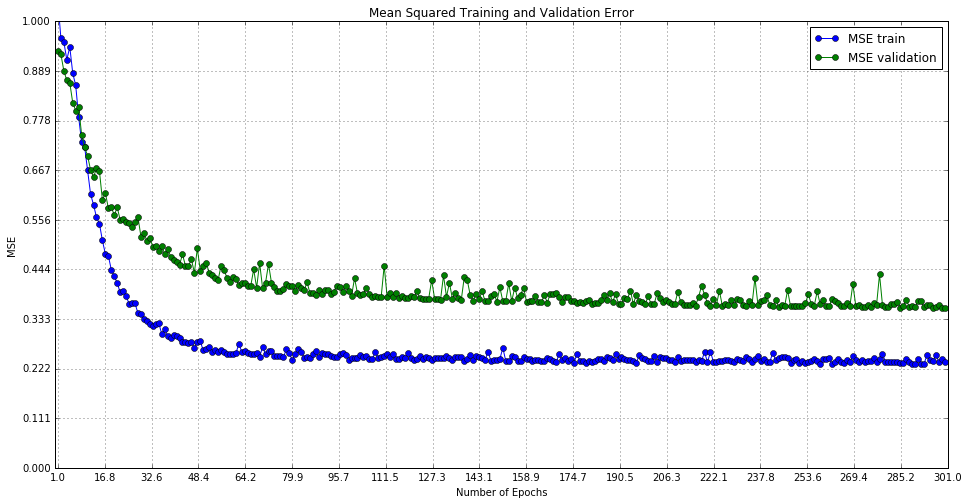

In [146]:
history_plot(hist)

<div id='2e' />
### Parte (e)

In [147]:
model = Sequential()
model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
model.add(Activation('relu'))
model.add(Dense(1, init='uniform'))
model.add(Activation('linear'))
model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')

In [148]:
hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
verbose=1, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))

Train on 379 samples, validate on 127 samples
Epoch 1/300
379/379 [==============================] - 0s - loss: 0.9418 - val_loss: 0.8649
Epoch 2/300
379/379 [==============================] - 0s - loss: 0.8247 - val_loss: 0.7844
Epoch 3/300
379/379 [==============================] - 0s - loss: 0.7150 - val_loss: 0.7110
Epoch 4/300
379/379 [==============================] - 0s - loss: 0.6121 - val_loss: 0.6476
Epoch 5/300
379/379 [==============================] - 0s - loss: 0.5209 - val_loss: 0.5976
Epoch 6/300
379/379 [==============================] - 0s - loss: 0.4480 - val_loss: 0.5604
Epoch 7/300
379/379 [==============================] - 0s - loss: 0.3909 - val_loss: 0.5312
Epoch 8/300
379/379 [==============================] - 0s - loss: 0.3478 - val_loss: 0.5070
Epoch 9/300
379/379 [==============================] - 0s - loss: 0.3141 - val_loss: 0.4857
Epoch 10/300
379/379 [==============================] - 0s - loss: 0.2869 - val_loss: 0.4669
Epoch 11/300
379/379 [===========

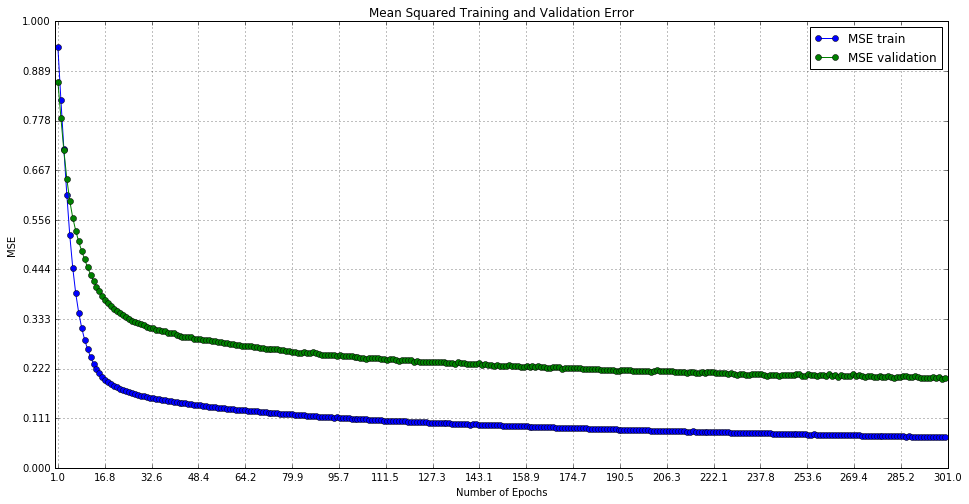

In [149]:
history_plot(hist)

<div id='2f' />
### Parte (f)

In [150]:
n_lr = 20
learning_rate = np.linspace(0, 0.03, n_lr+1)[1::]
hist_list = list()

for i in range(n_lr):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=learning_rate[i]), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

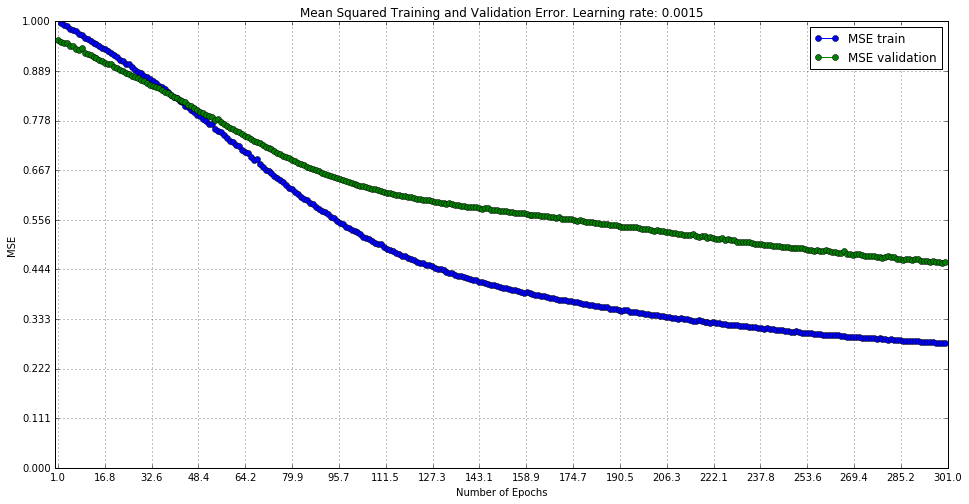

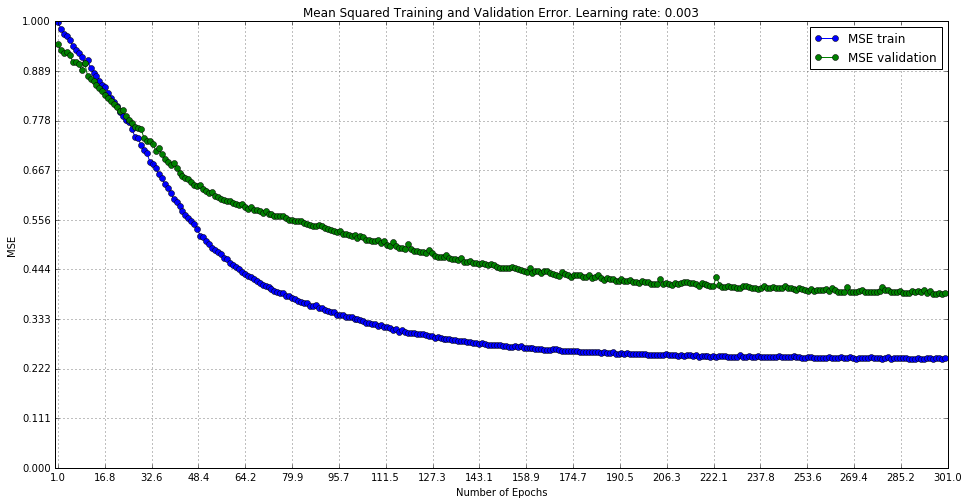

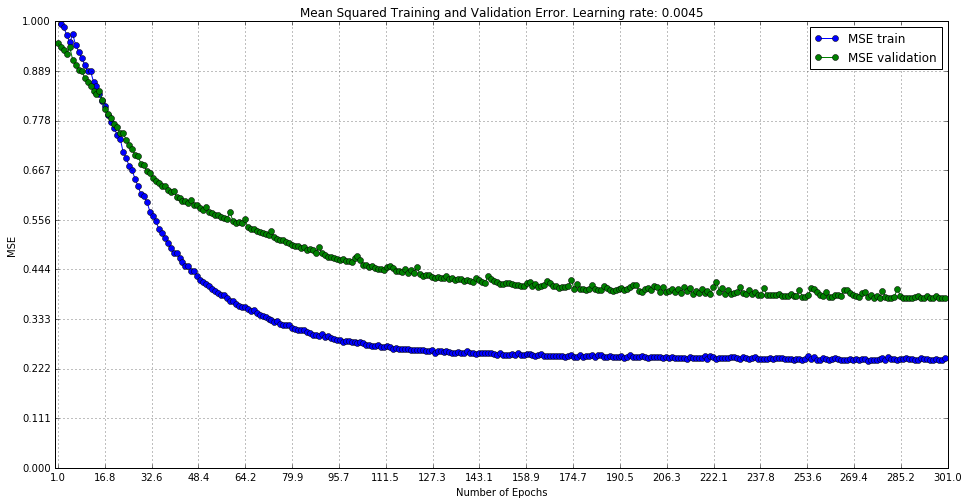

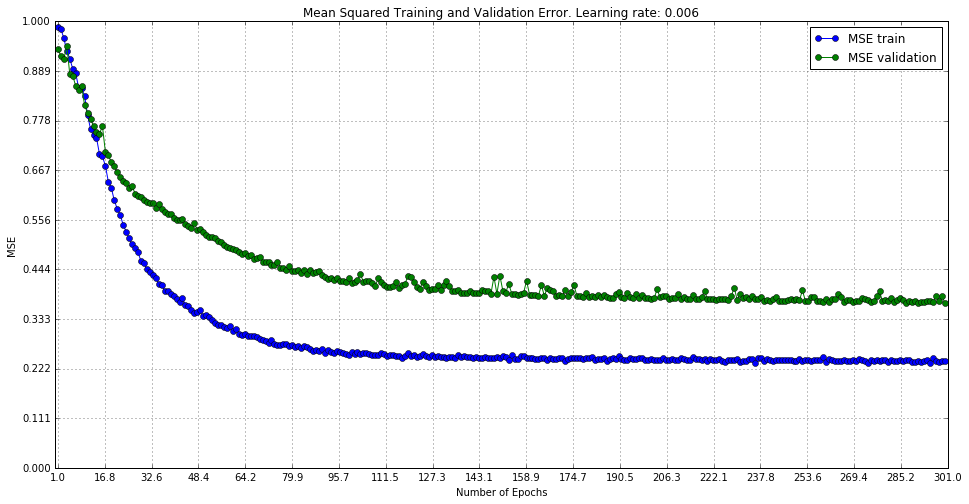

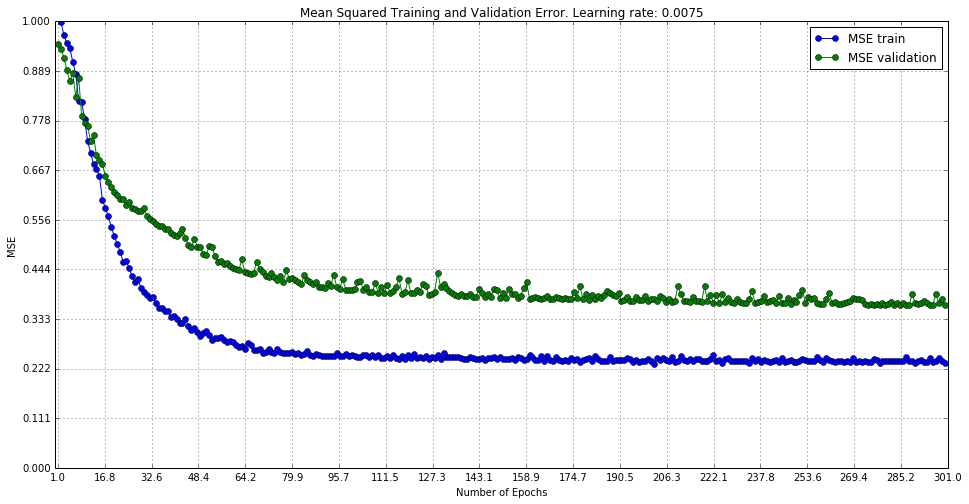

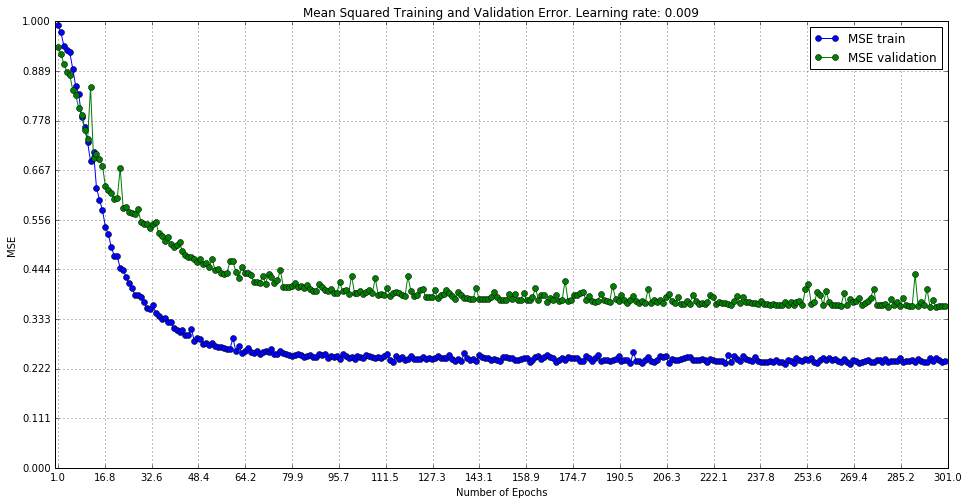

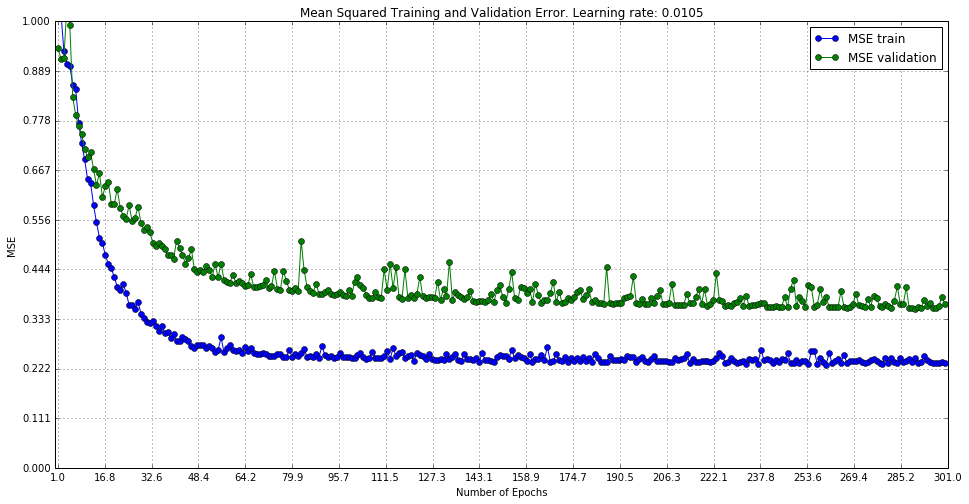

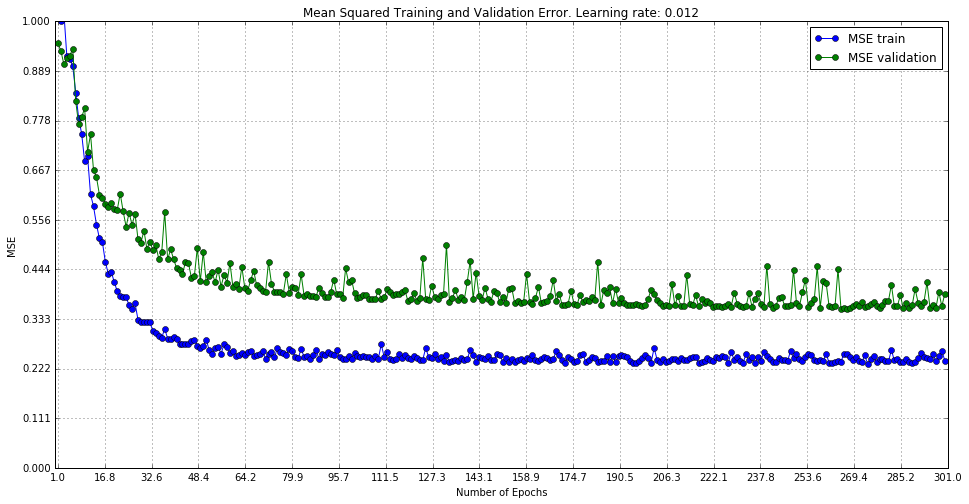

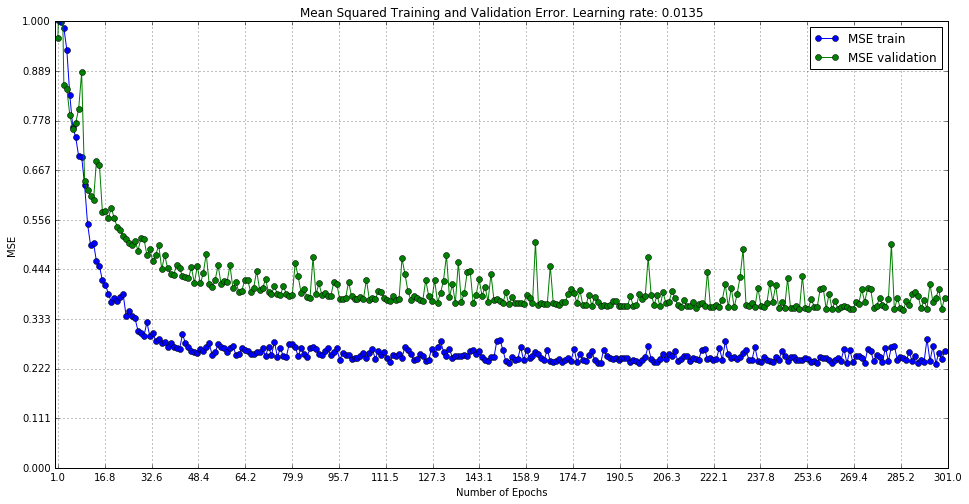

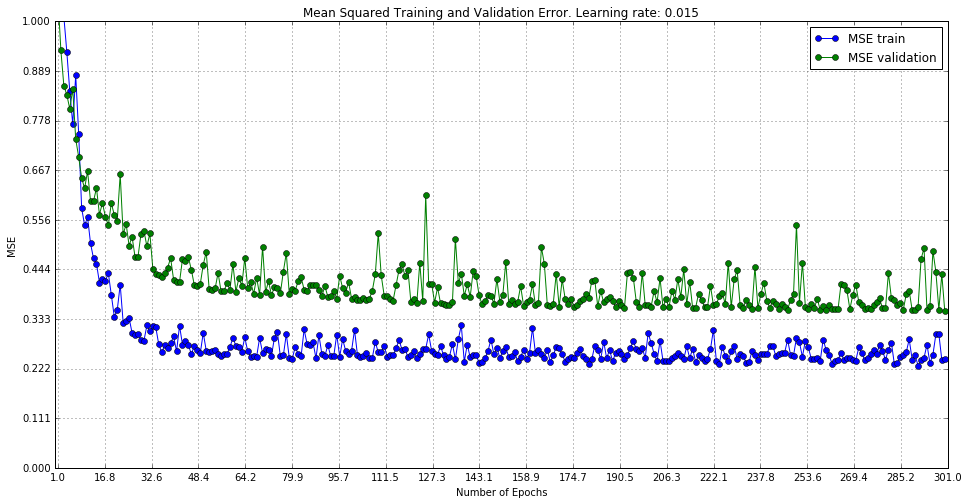

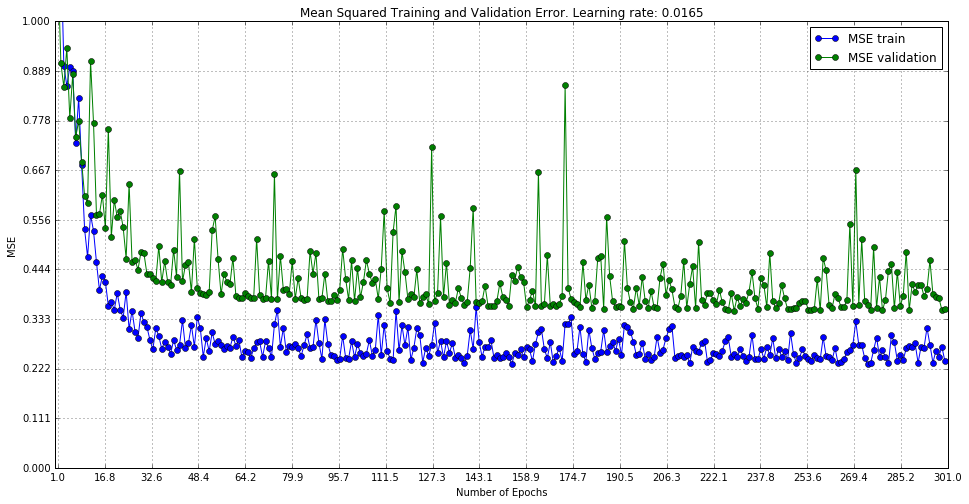

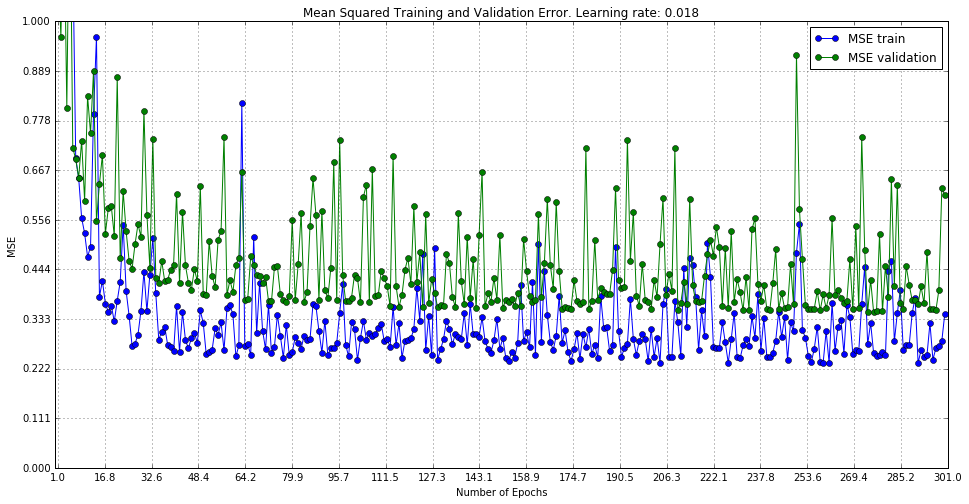

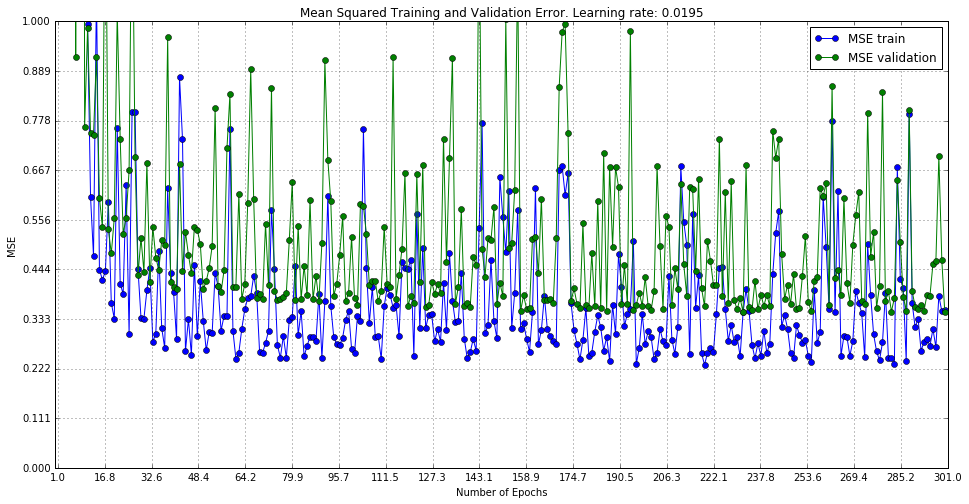

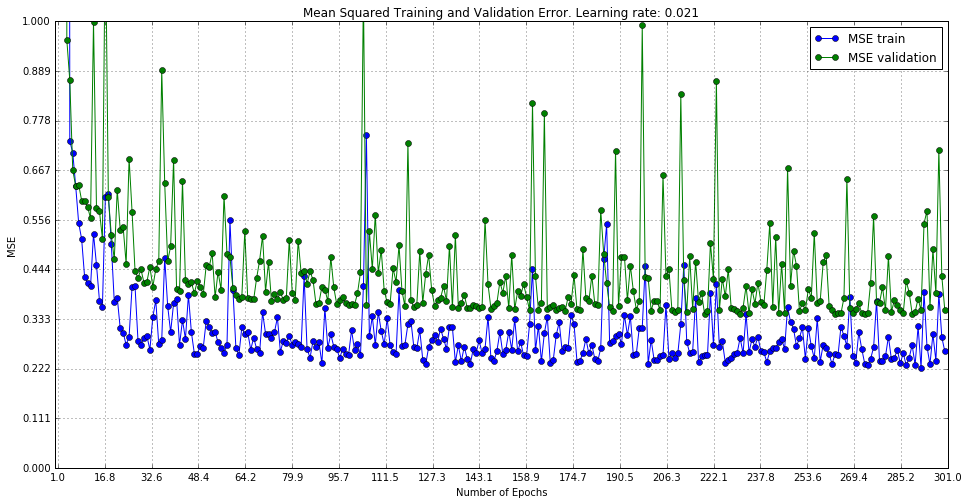

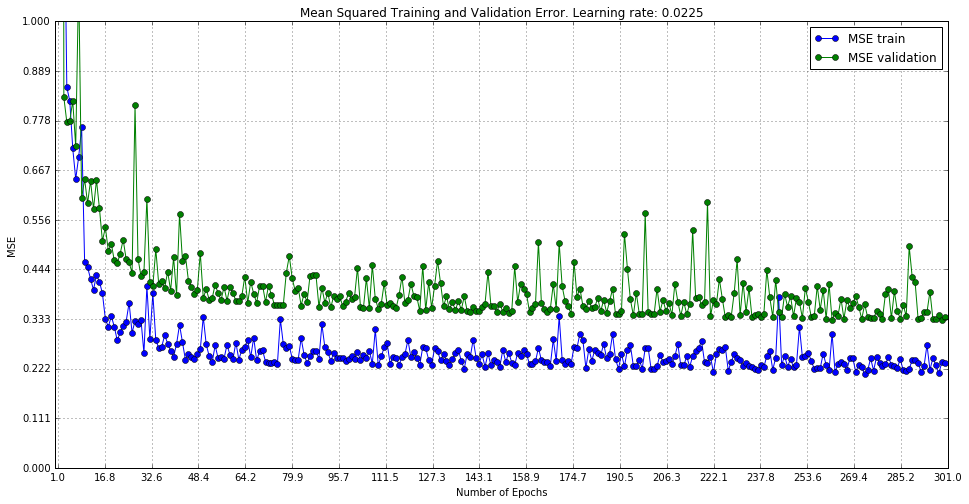

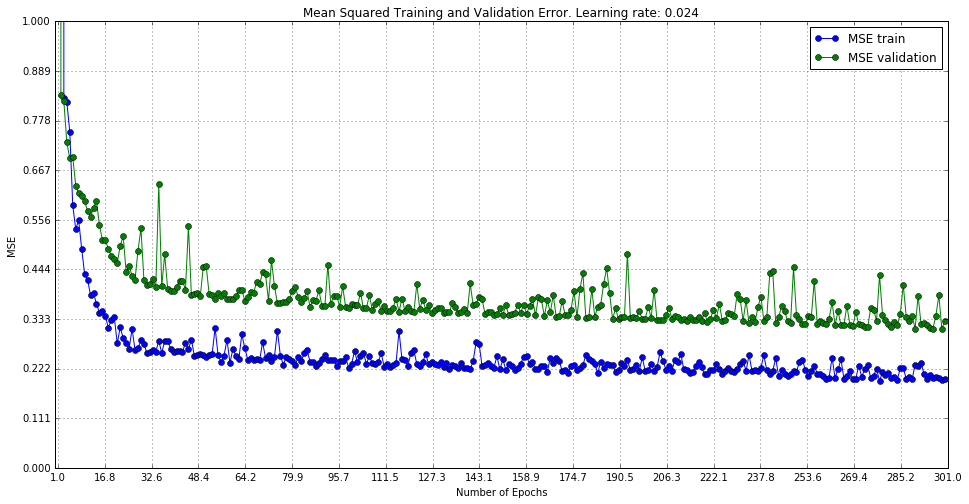

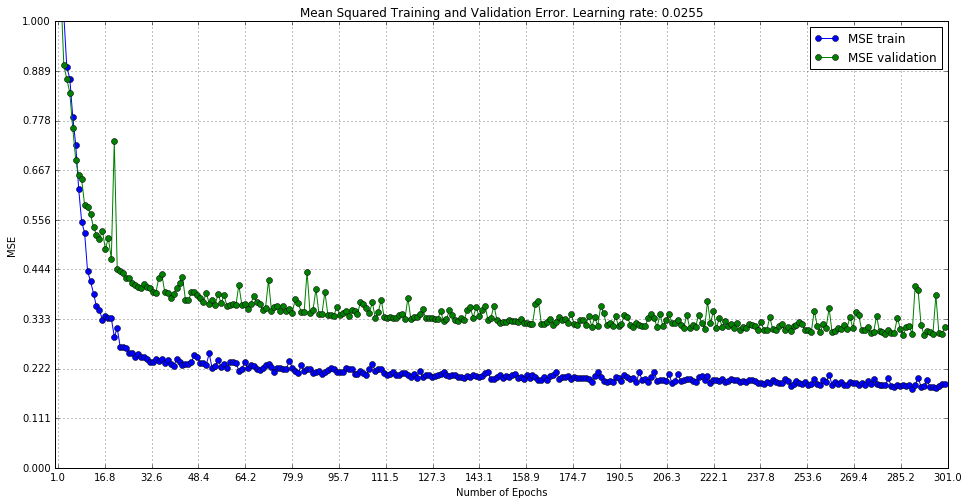

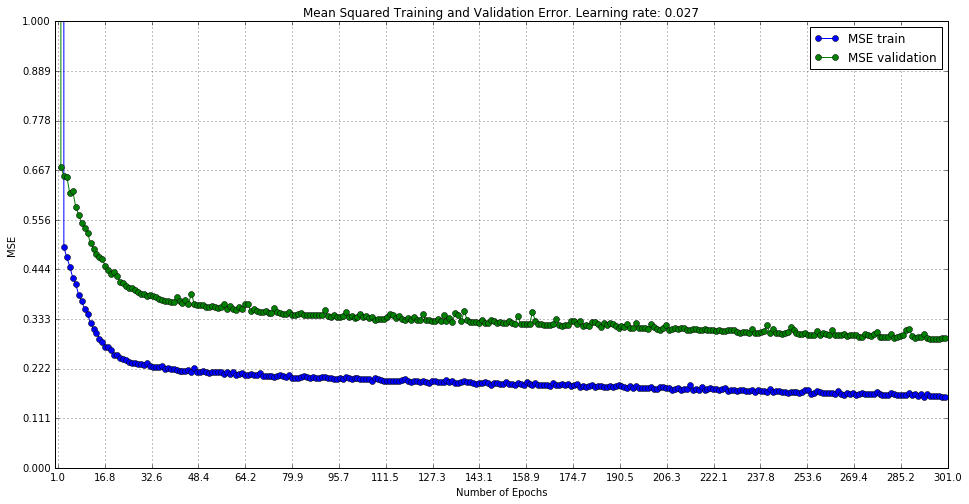

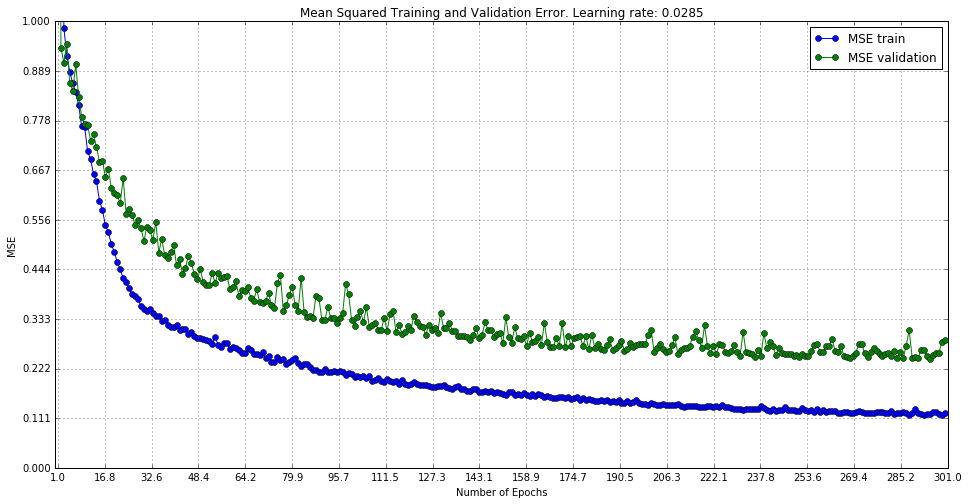

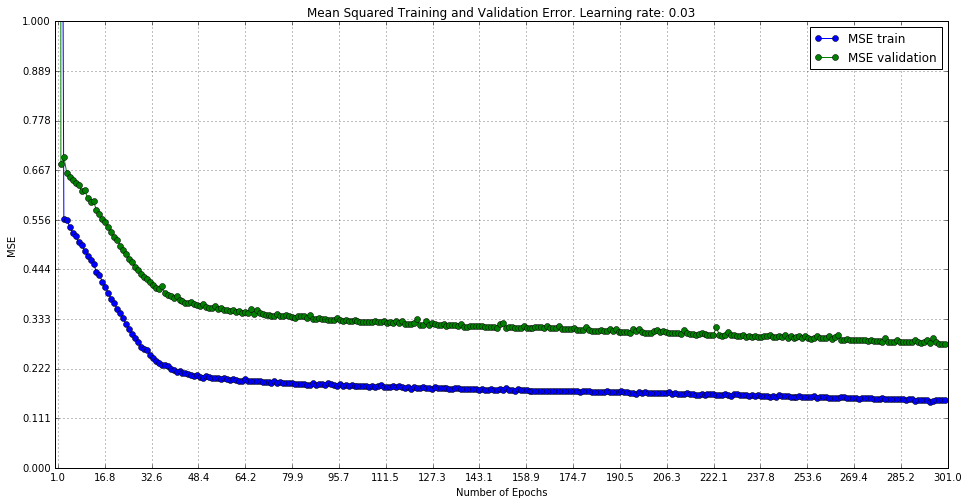

In [152]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Learning rate: {0}'.format(learning_rate[i])
    history_plot(hist, title)

<div id='2g' />
### Parte (g)

#### 5-Fold Cross Validation

In [112]:
Xm = X_train_scaled.as_matrix()
ym = y_train_scaled.as_matrix()
kfold = KFold(len(Xm), 5)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)

32/75 [===========>..................] - ETA: 0s

In [113]:
mse_cv

0.26704990021492303

#### 10-Fold Cross Validation

In [114]:
kfold = KFold(len(Xm), 10)
cvscores = []

for i, (train, val) in enumerate(kfold):
    # create model
    model = Sequential()
    model.add(Dense(200, input_dim=Xm.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    # Compile model
    sgd = SGD(lr=0.01)
    model.compile(optimizer=sgd, loss='mean_squared_error')
    # Fit the model
    model.fit(Xm[train], ym[train], nb_epoch=300, verbose=0)
    # evaluate the model
    scores = model.evaluate(Xm[val], ym[val])
    cvscores.append(scores)
mse_cv = np.mean(cvscores)

32/37 [========================>.....] - ETA: 0s

In [115]:
mse_cv

0.27104718351053075

<div id='2h' />
### Parte (h)

In [153]:
n_decay = 10
learning_decay = np.logspace(-6, 0, n_decay)
hist_list = list()

for i in range(n_decay):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01, decay=learning_decay[i]), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

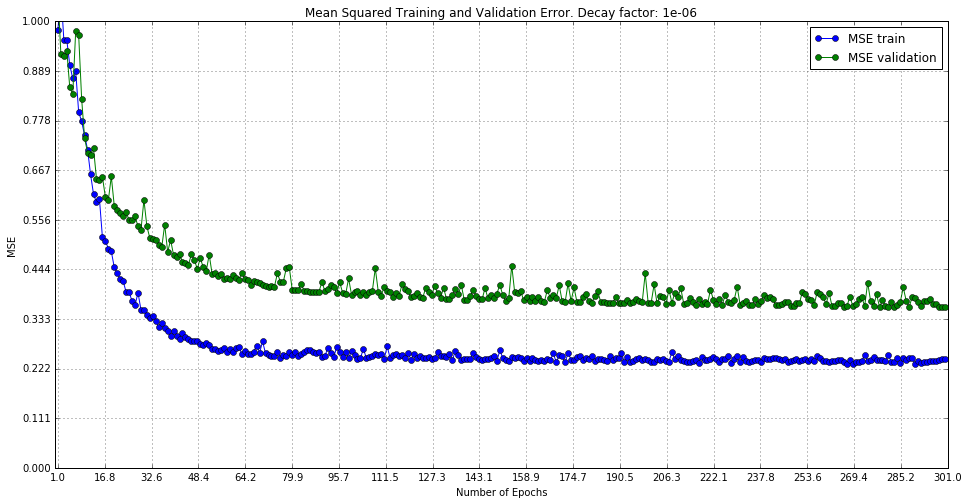

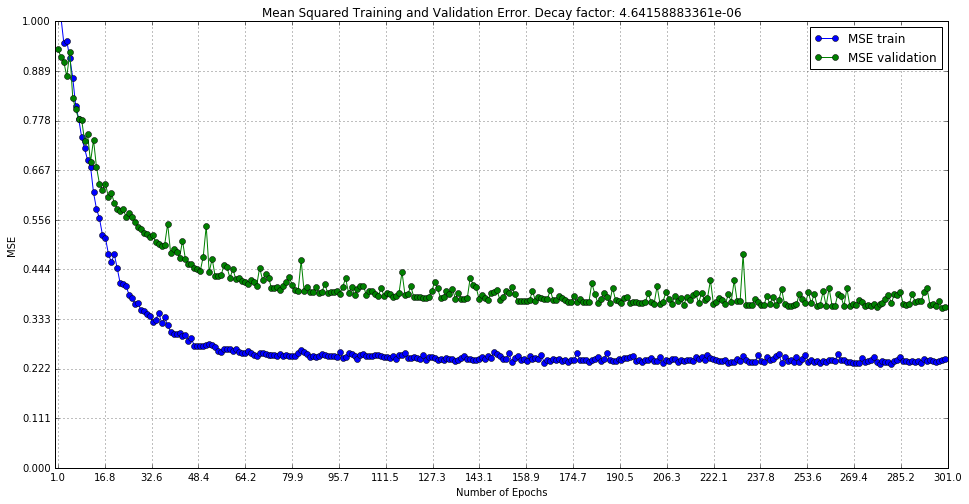

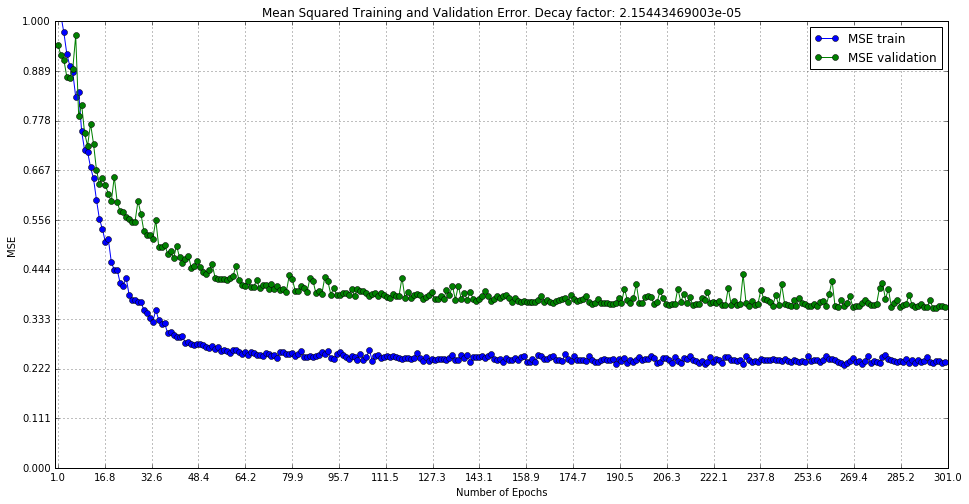

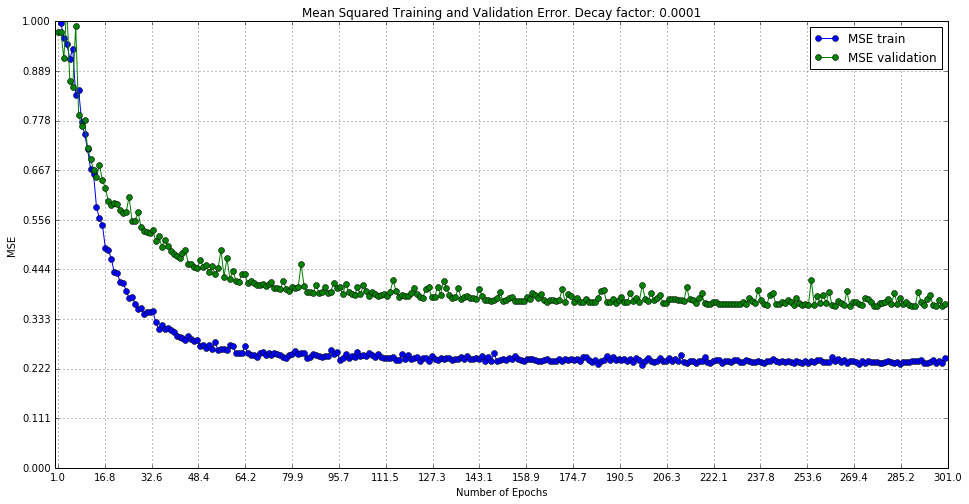

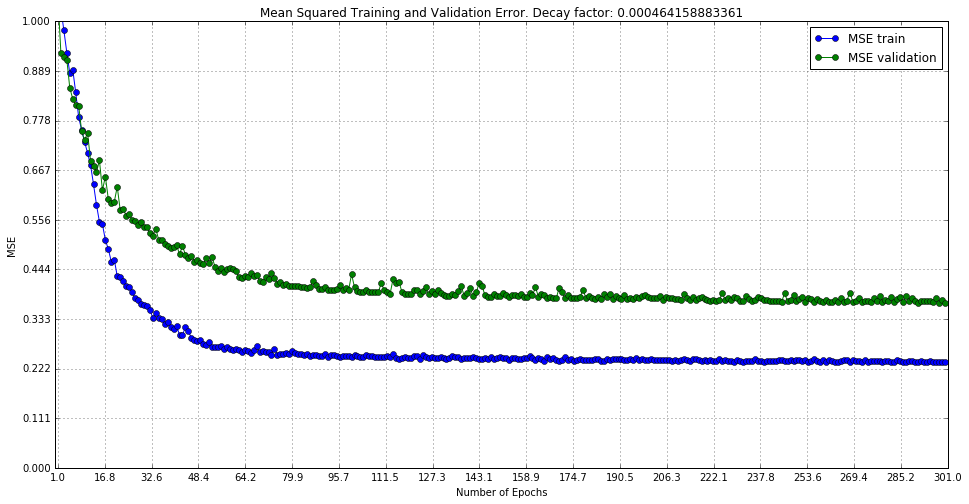

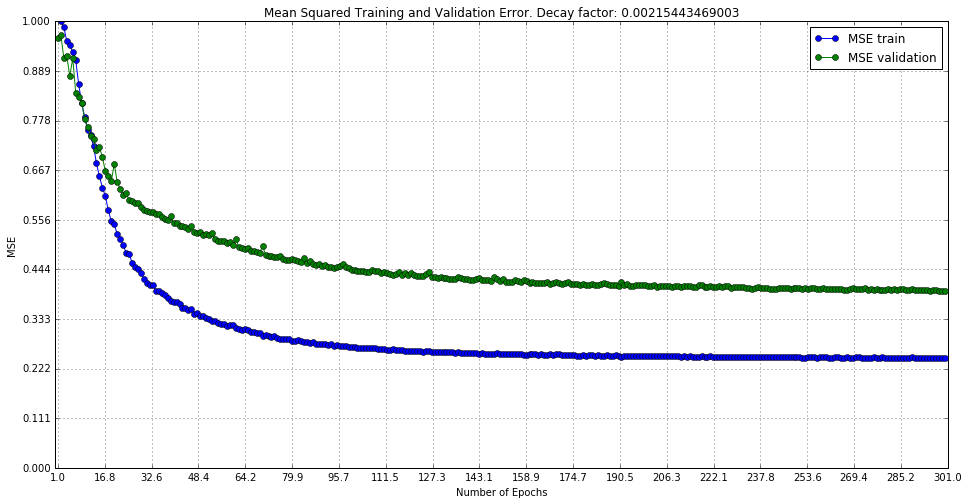

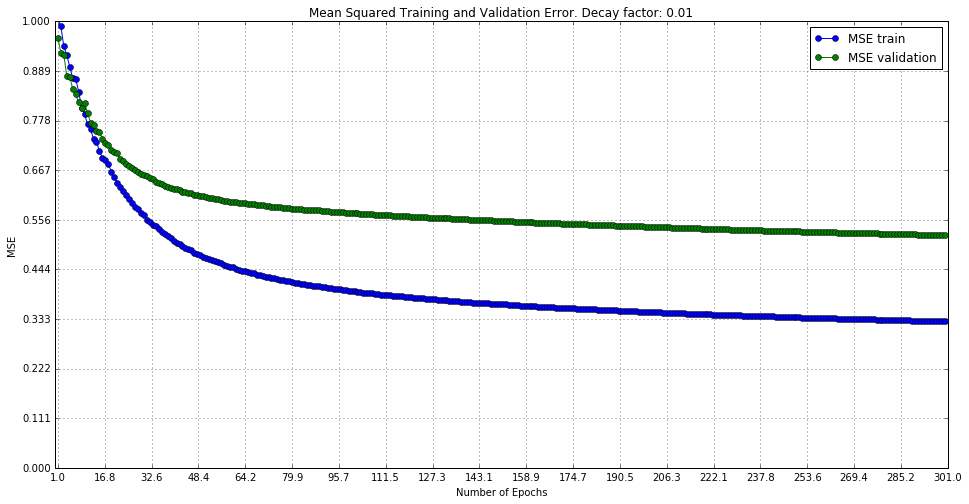

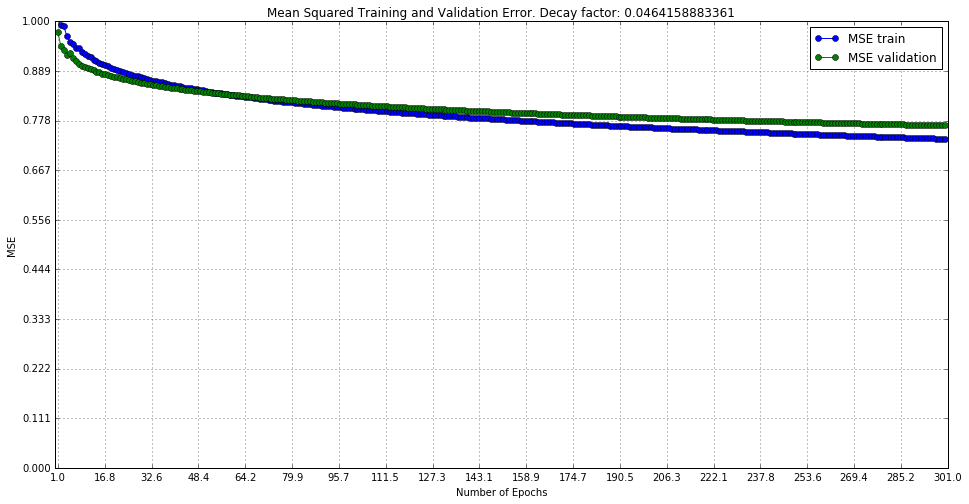

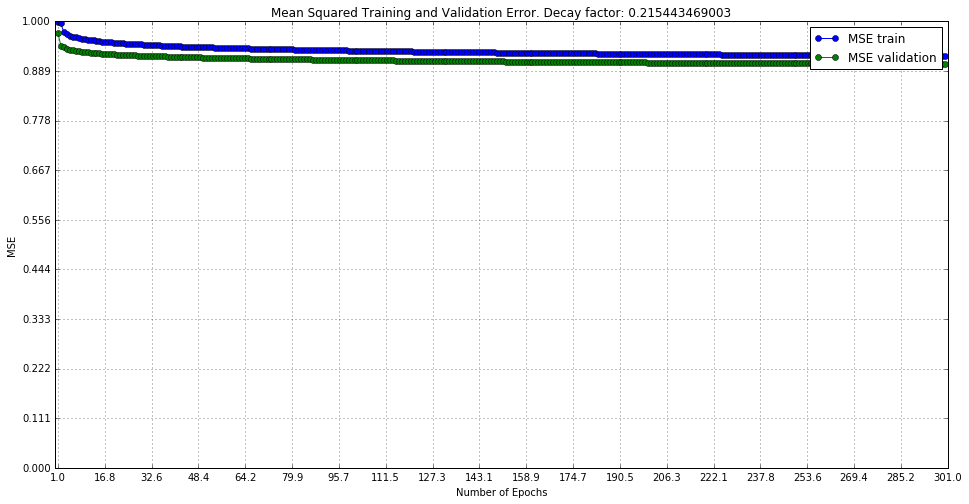

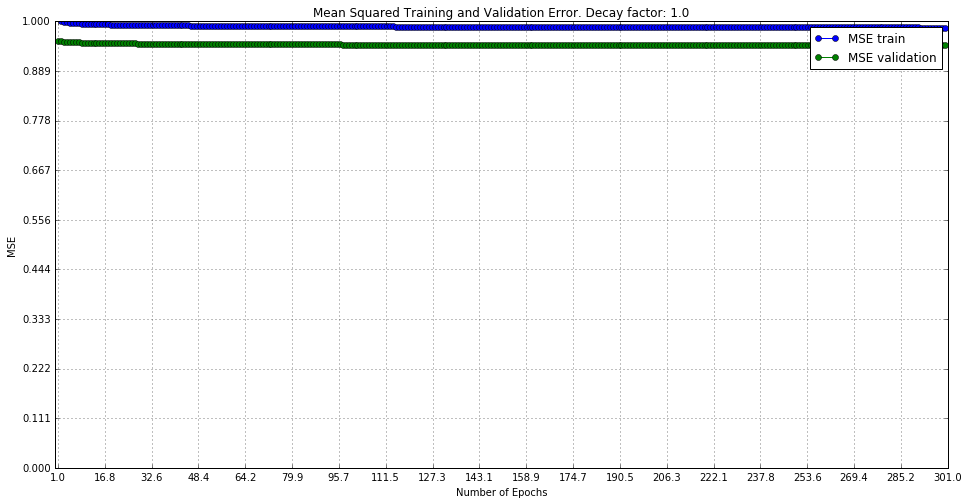

In [154]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Decay factor: {0}'.format(learning_decay[i])
    history_plot(hist, title)

<div id='2i' />
### Parte (i)

In [155]:
n_momentum = 20
momentum = np.linspace(0., 1., n_momentum+1)[1::]
hist_list = list()

for i in range(n_momentum):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01, decay=momentum[i]), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300,
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

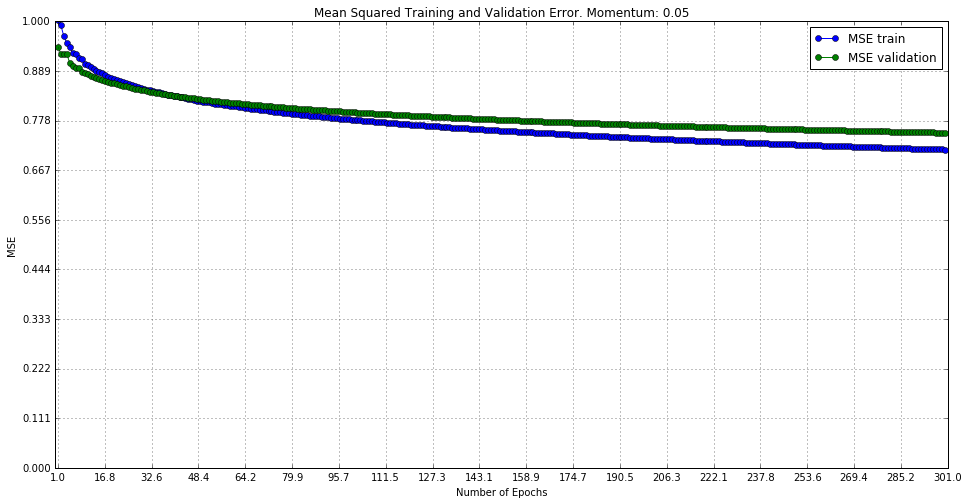

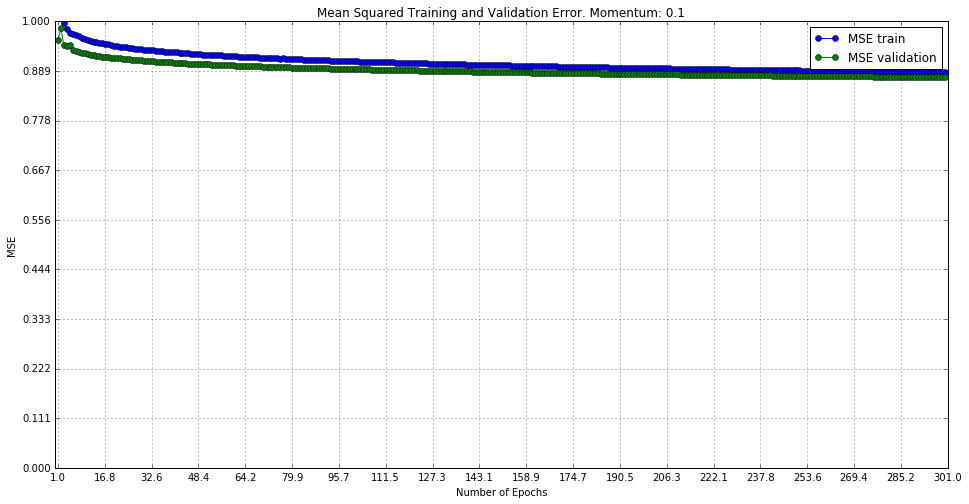

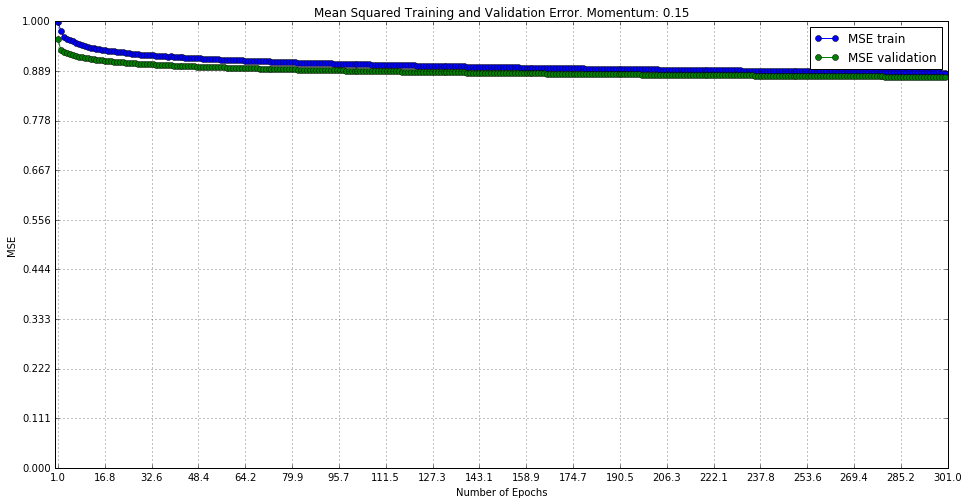

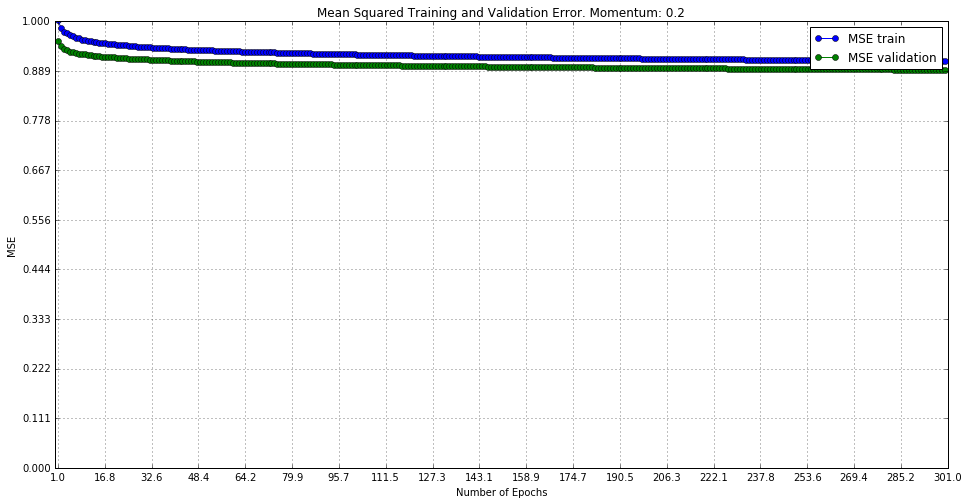

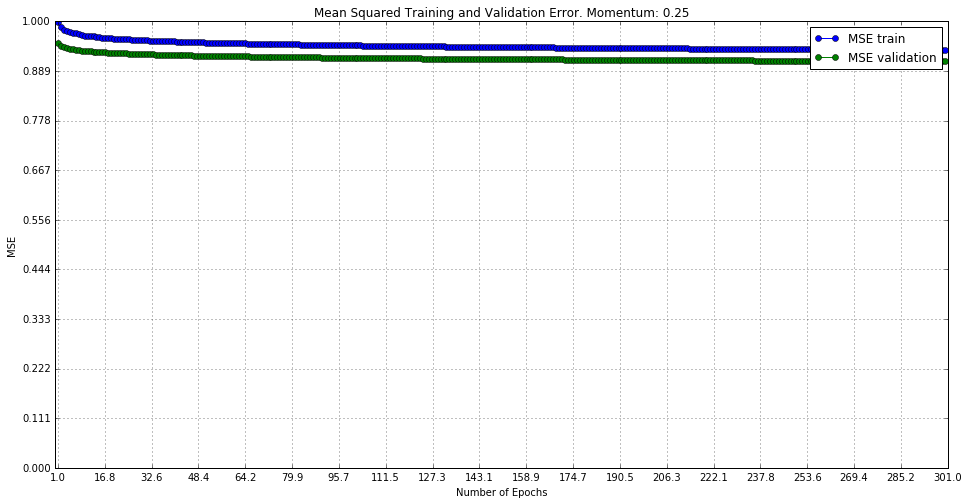

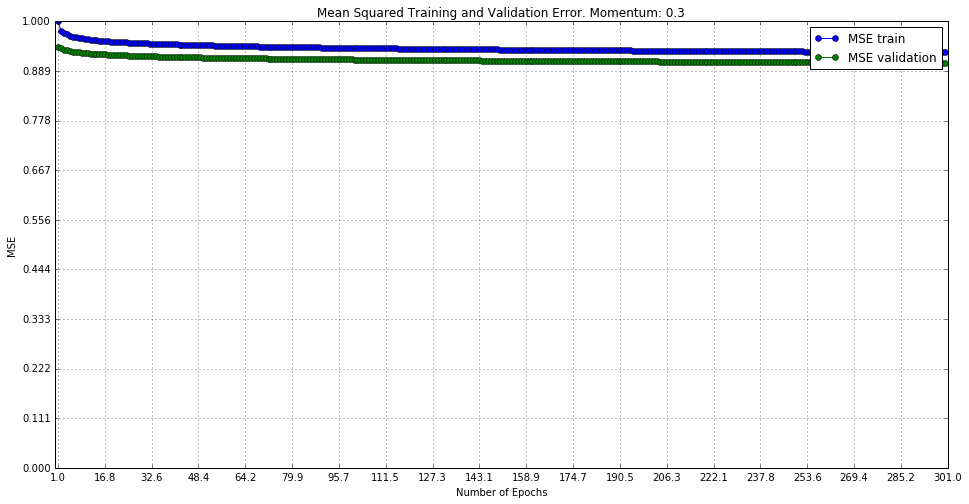

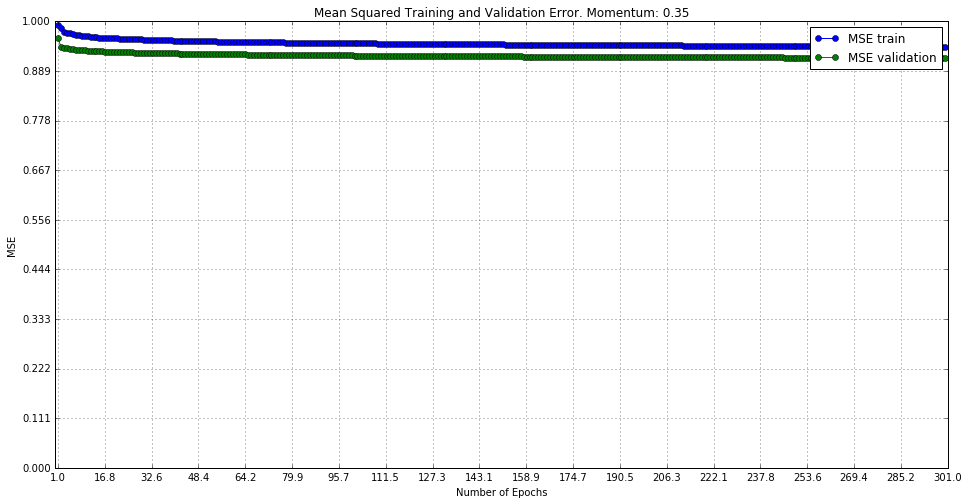

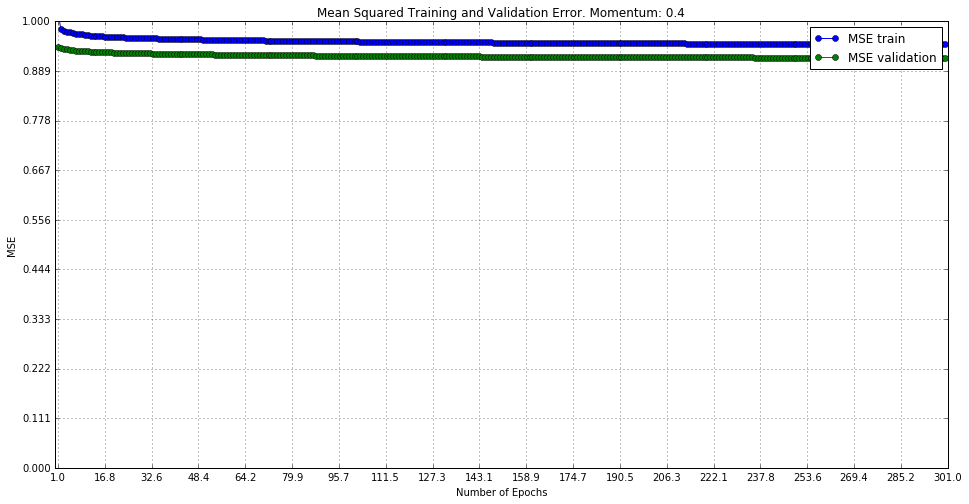

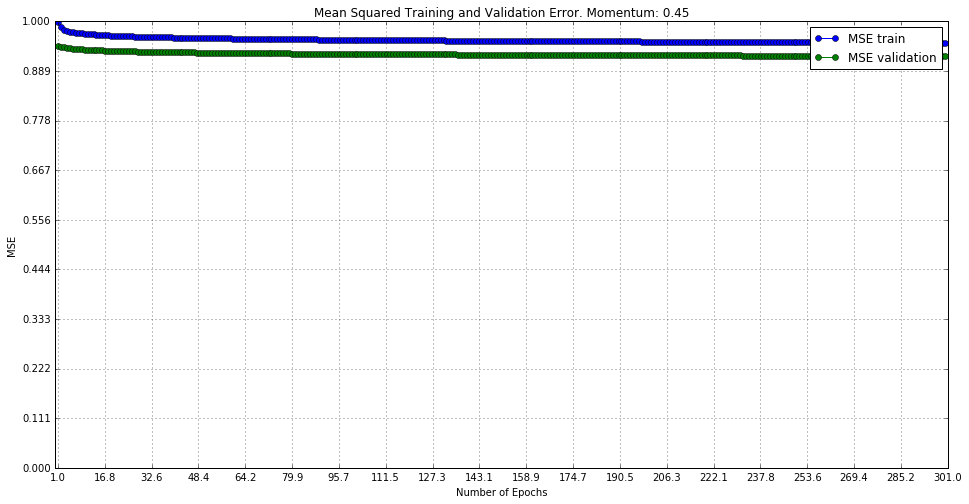

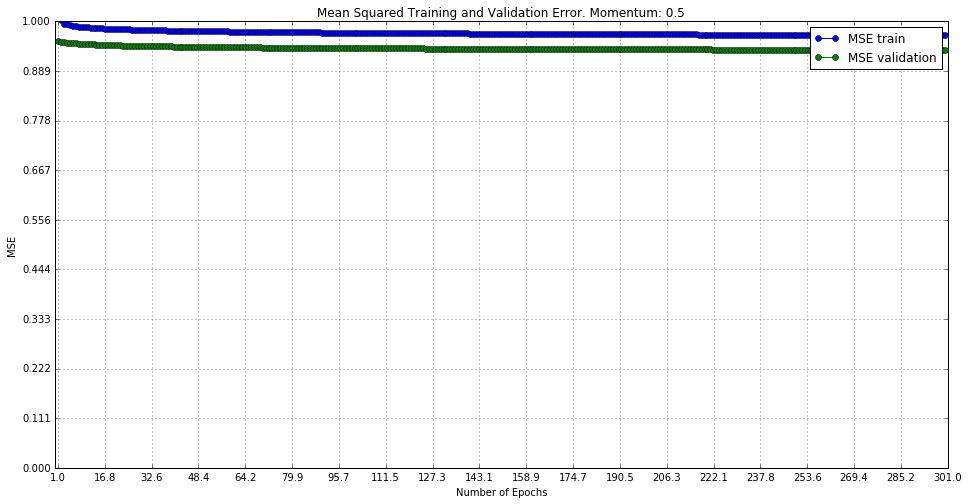

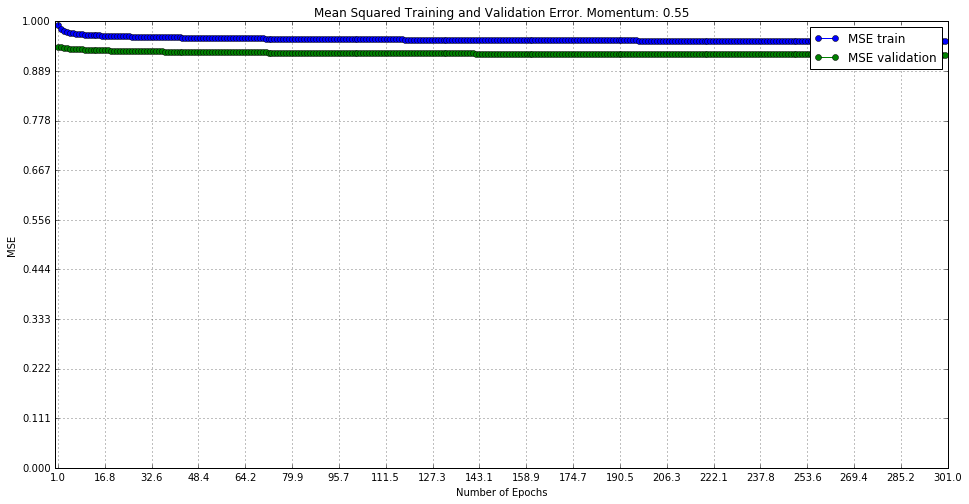

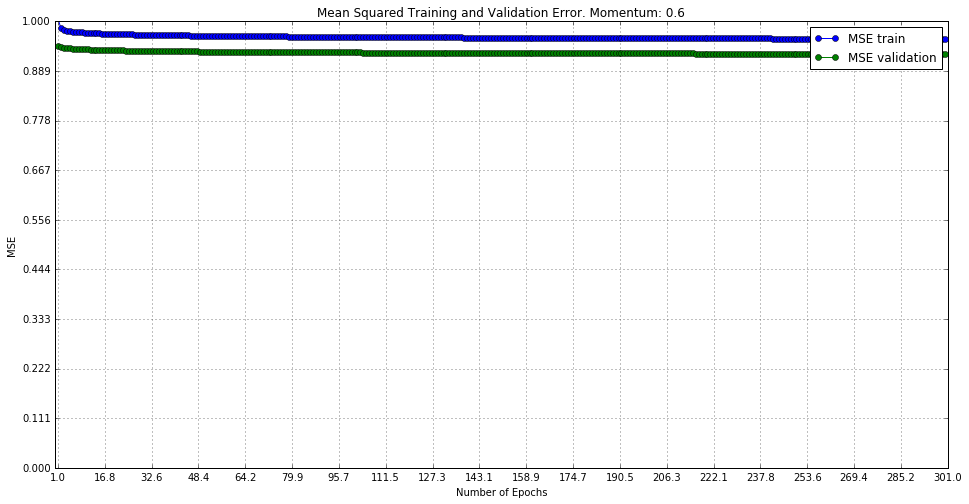

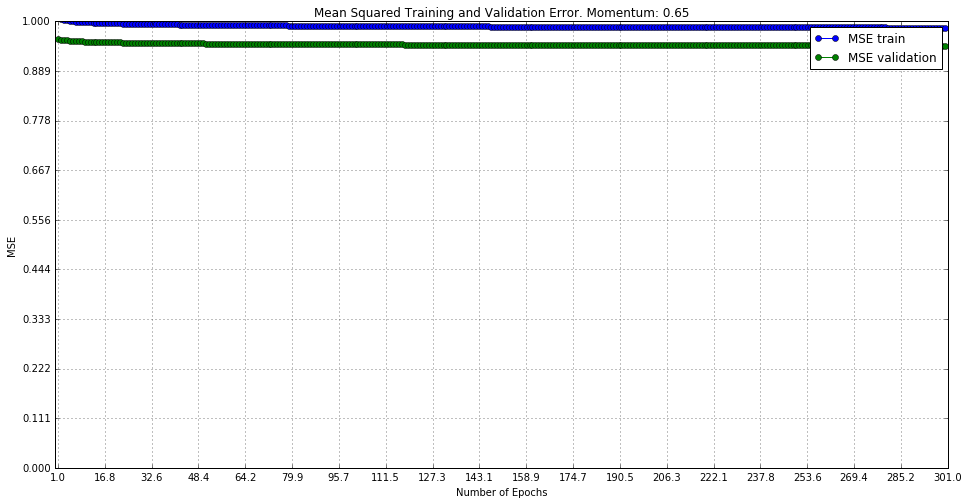

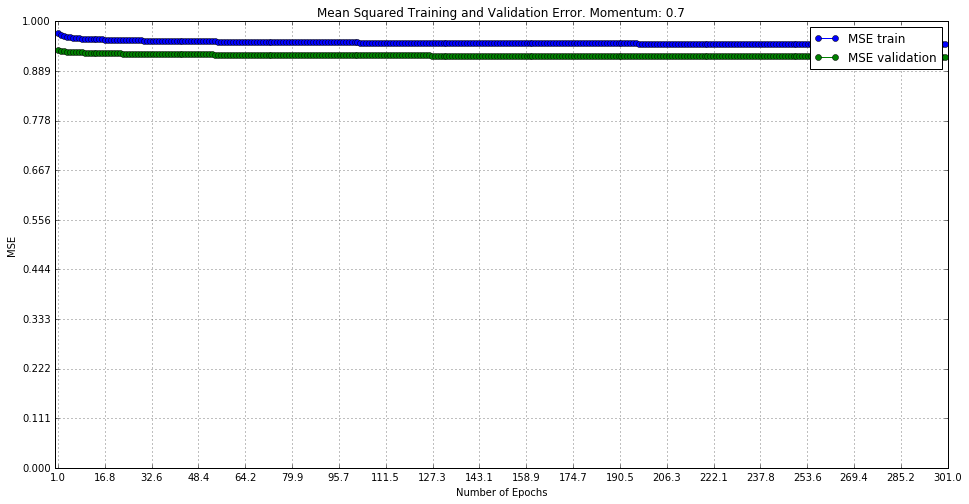

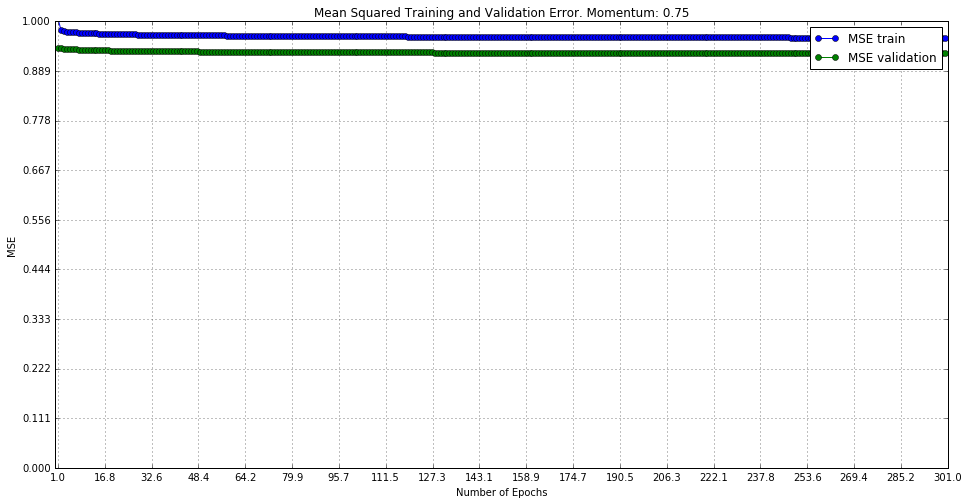

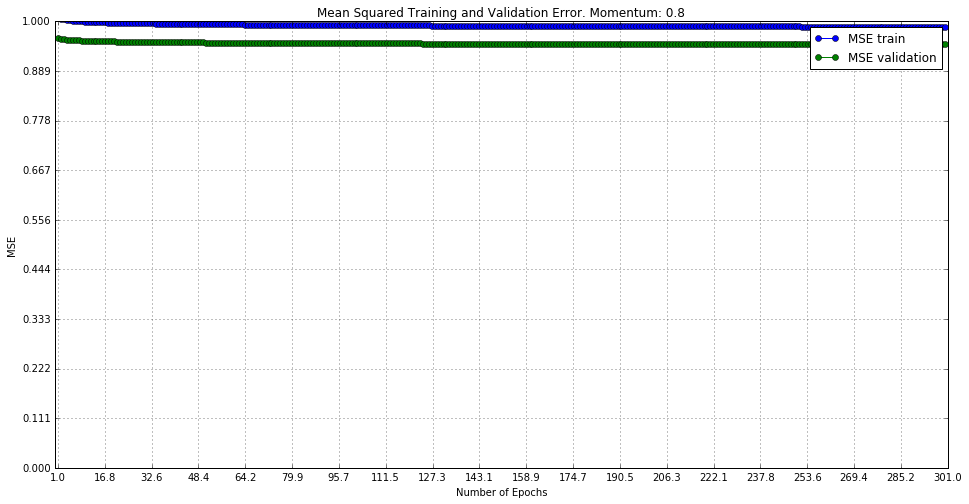

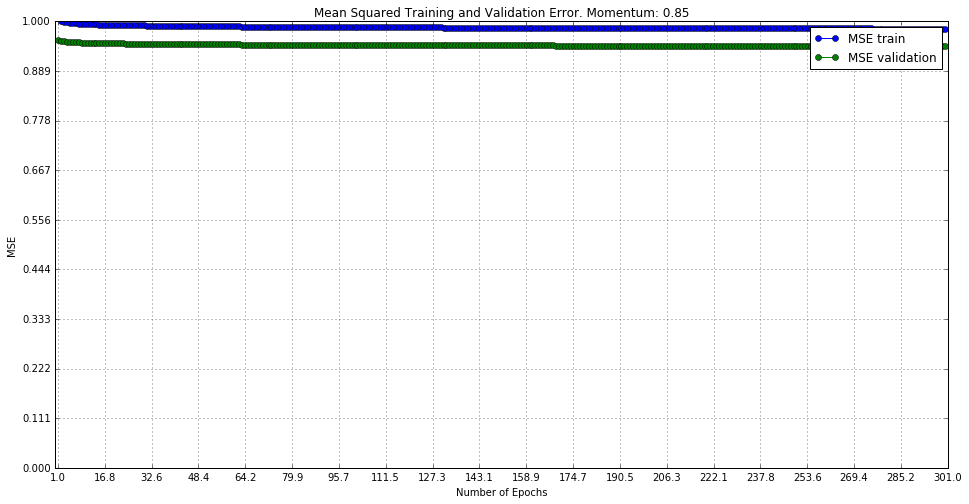

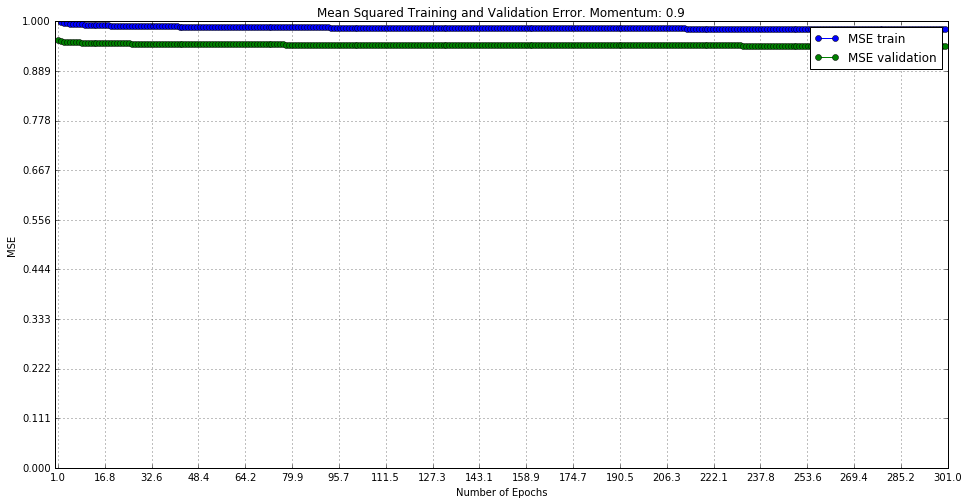

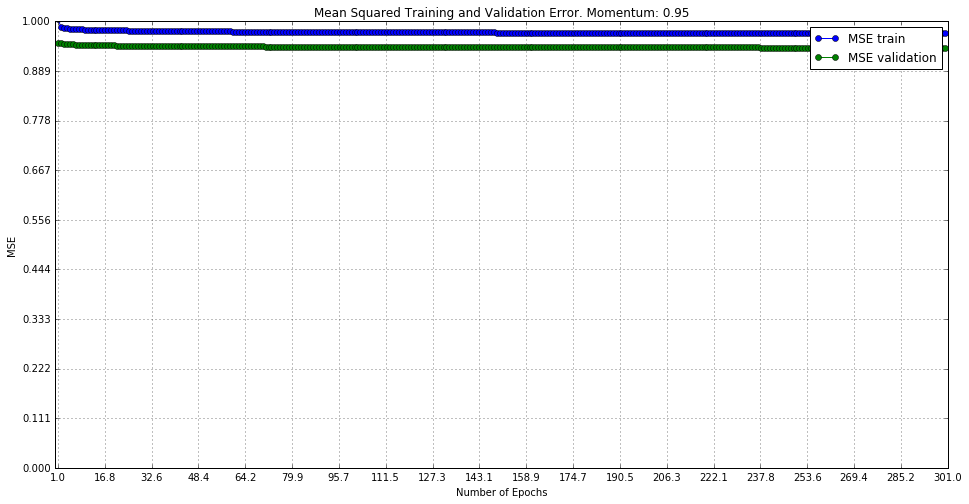

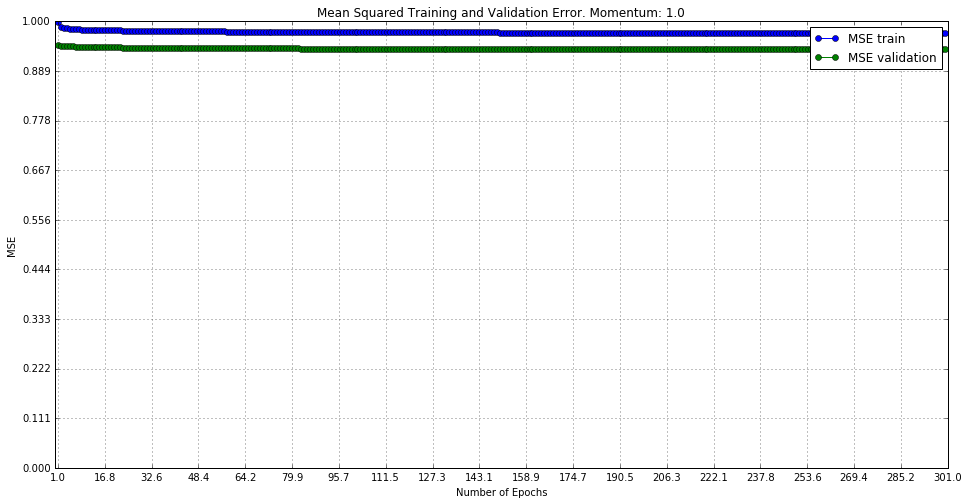

In [156]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Momentum: {0}'.format(momentum[i])
    history_plot(hist, title)

<div id='2j' />
### Parte (j)

In [158]:
n_batches = 20
batch_sizes = np.round(np.linspace(1,X_train_scaled.shape[0],n_batches))
print(batch_sizes)

[   1.   21.   41.   61.   81.  100.  120.  140.  160.  180.  200.  220.
  240.  260.  280.  299.  319.  339.  359.  379.]


In [159]:
hist_list = list()

for i in range(n_batches):
    # building the model
    model = Sequential()
    model.add(Dense(output_dim=200, input_dim=X_train_scaled.shape[1], init='uniform'))
    model.add(Activation('sigmoid'))
    model.add(Dense(1, init='uniform'))
    model.add(Activation('linear'))
    model.compile(optimizer=SGD(lr=0.01), loss='mean_squared_error')
    # training the network
    hist = model.fit(X_train_scaled.as_matrix(), y_train_scaled.as_matrix(), nb_epoch=300, batch_size=batch_sizes[i],
    verbose=0, validation_data=(X_test_scaled.as_matrix(), y_test_scaled.as_matrix()))
    # storing the results
    hist_list.append(hist)

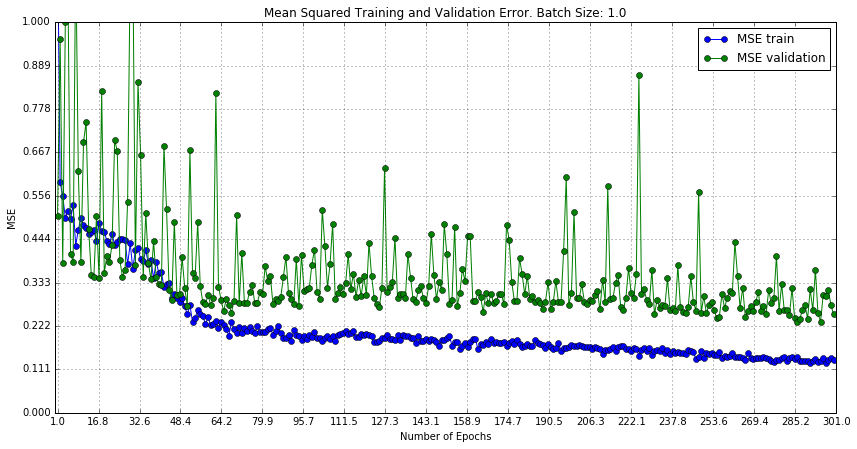

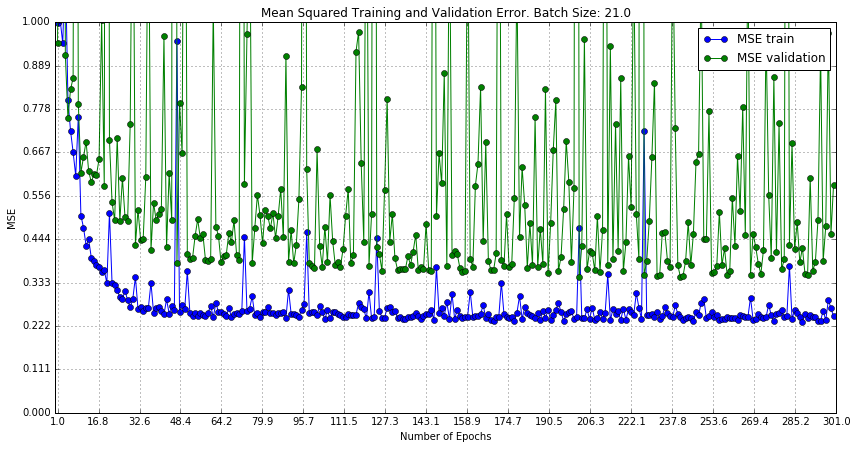

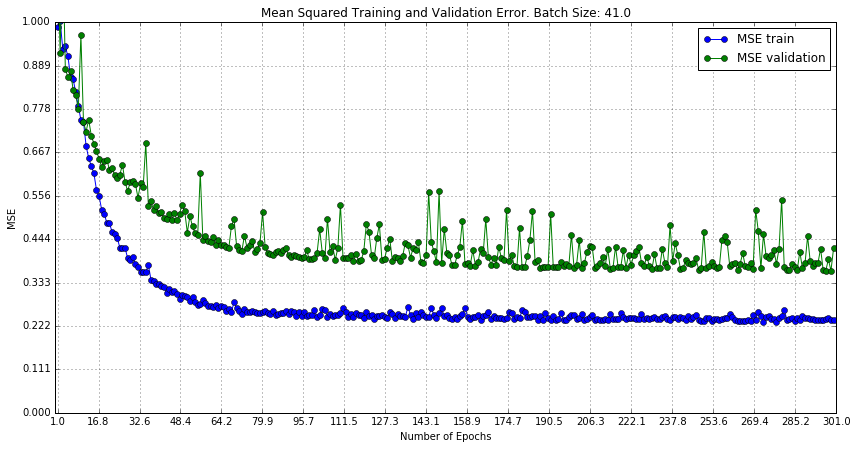

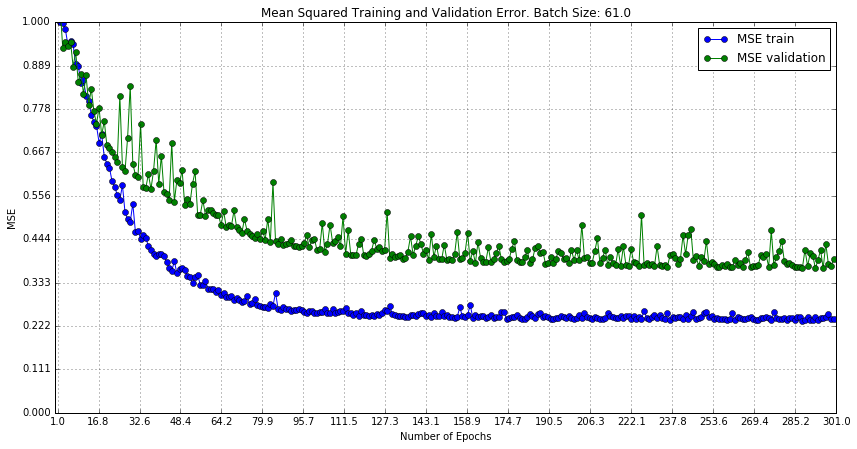

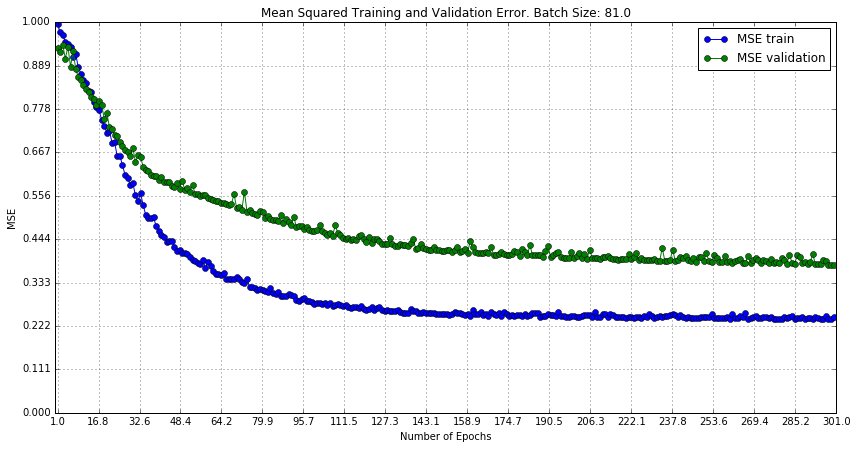

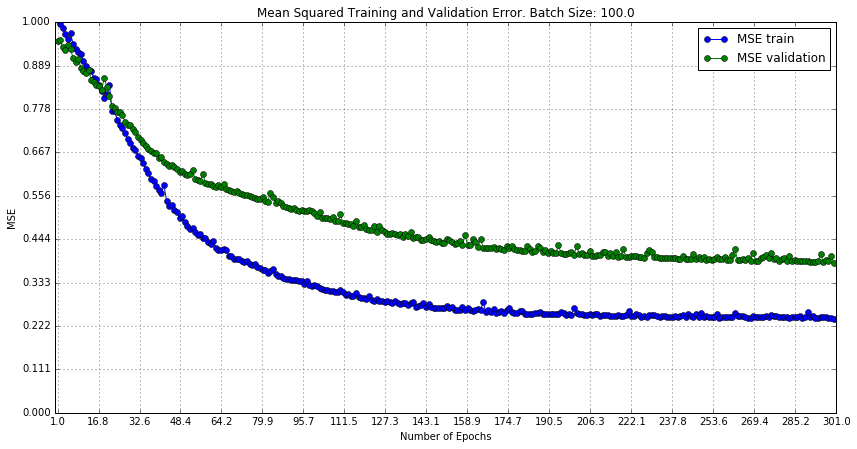

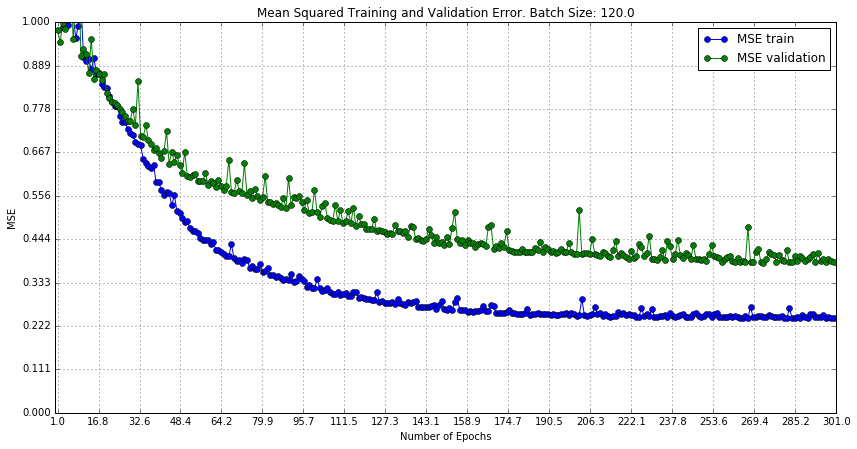

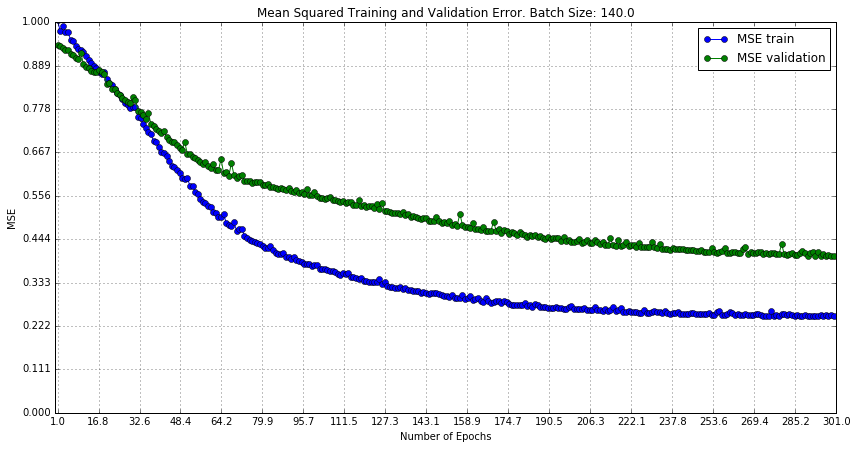

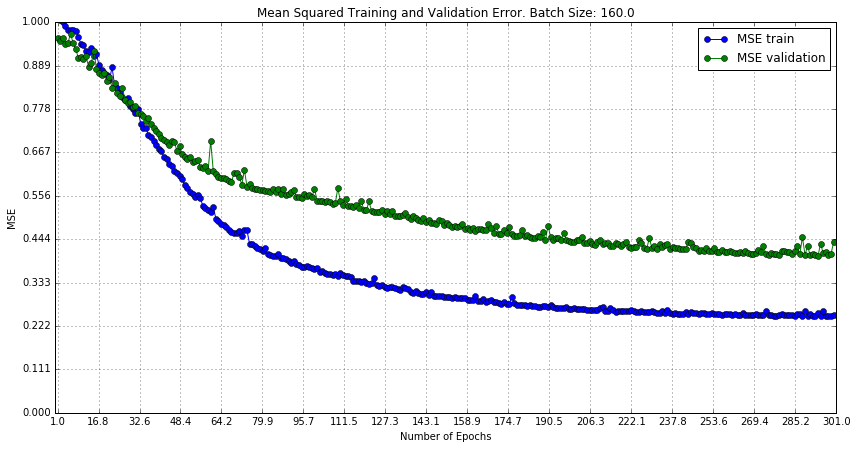

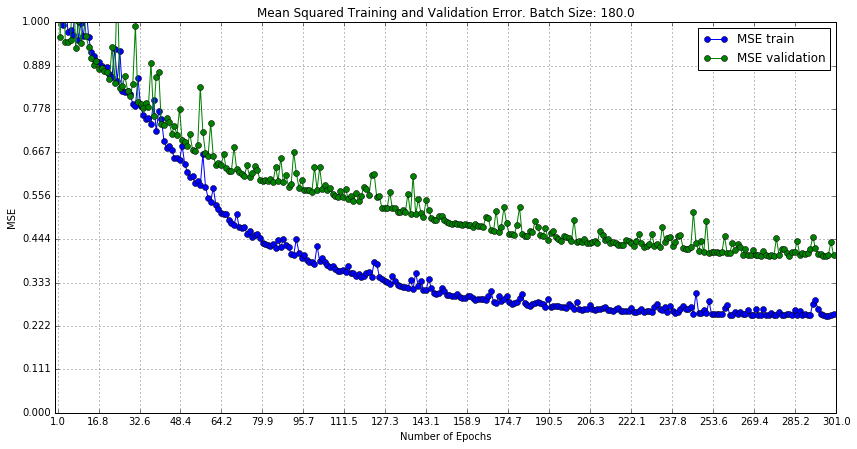

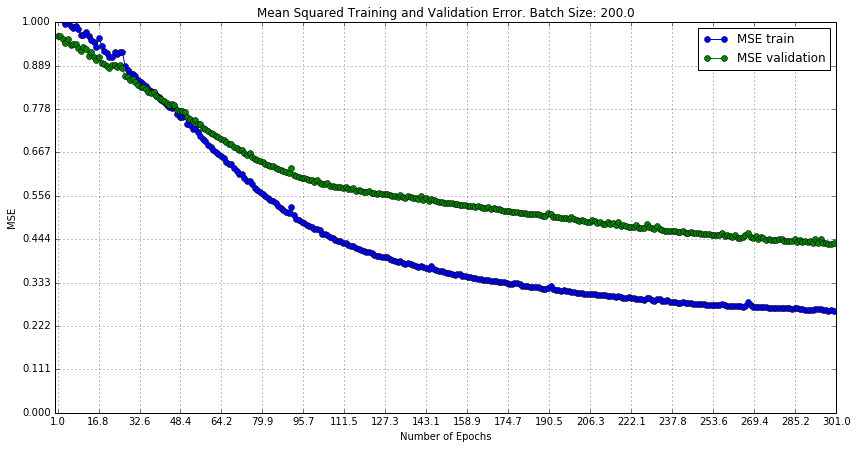

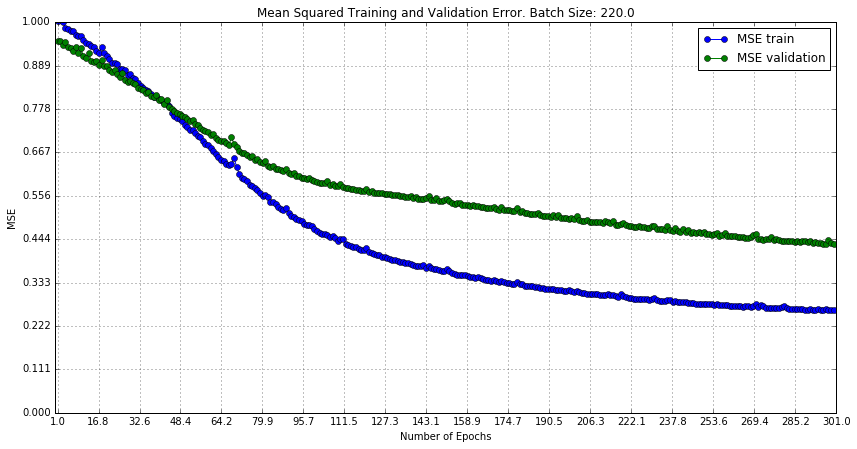

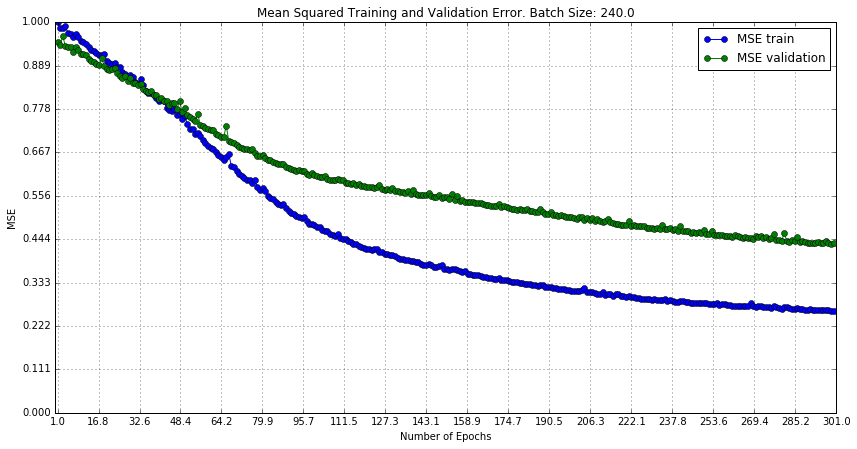

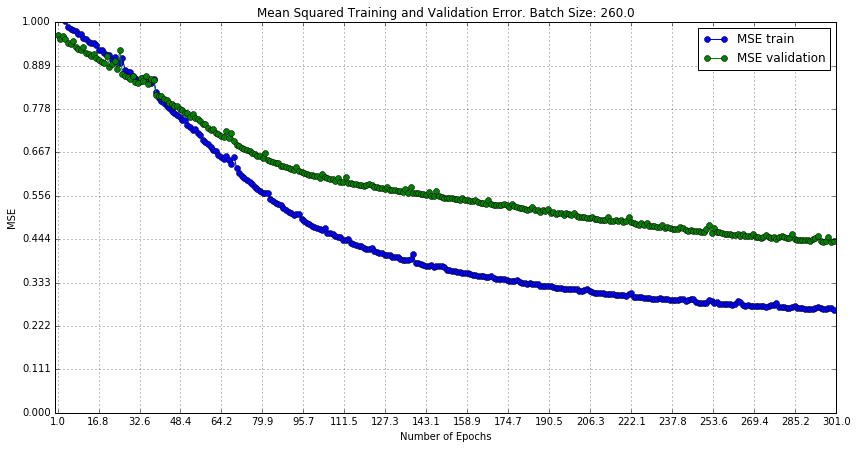

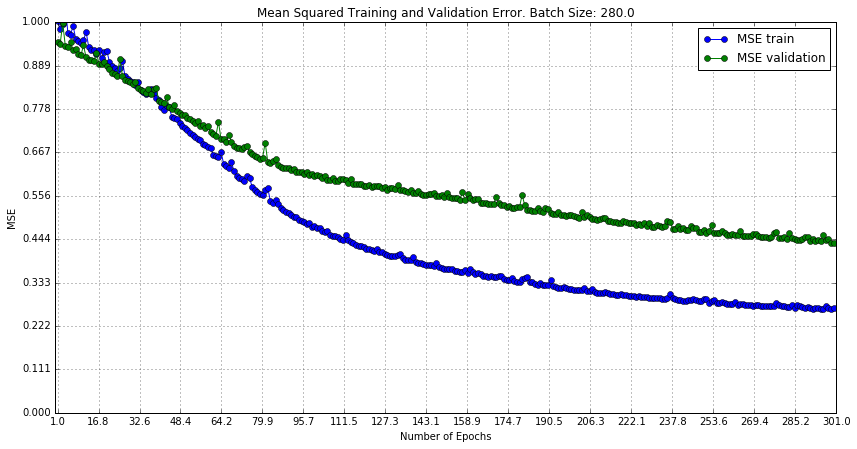

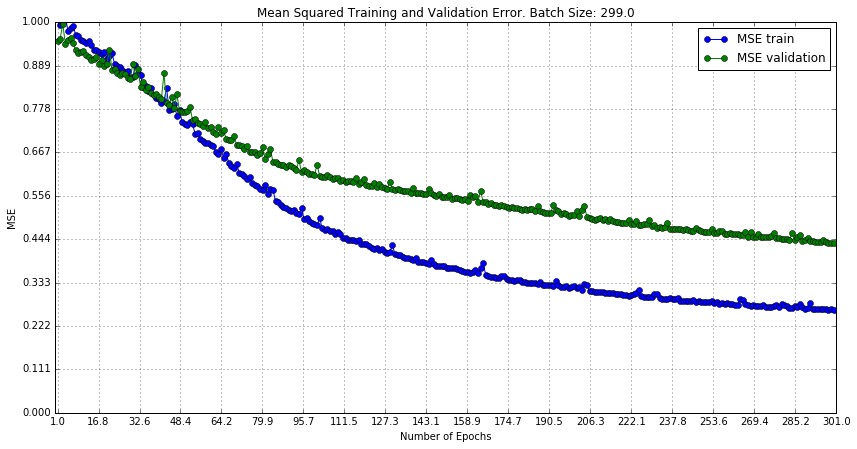

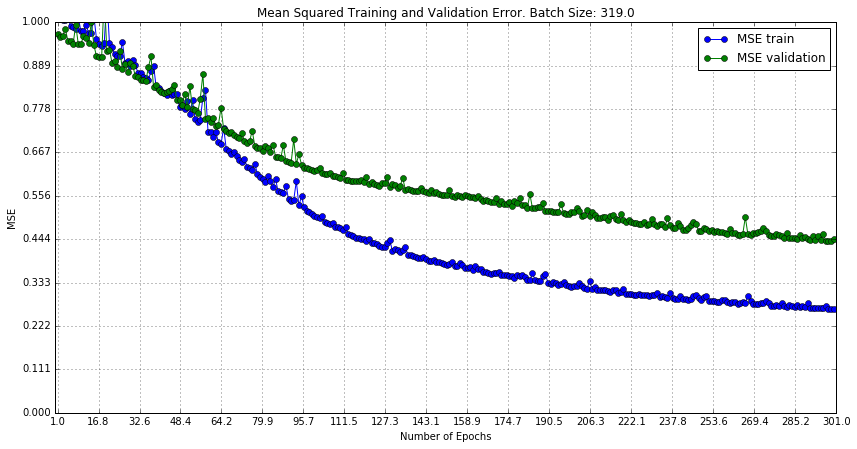

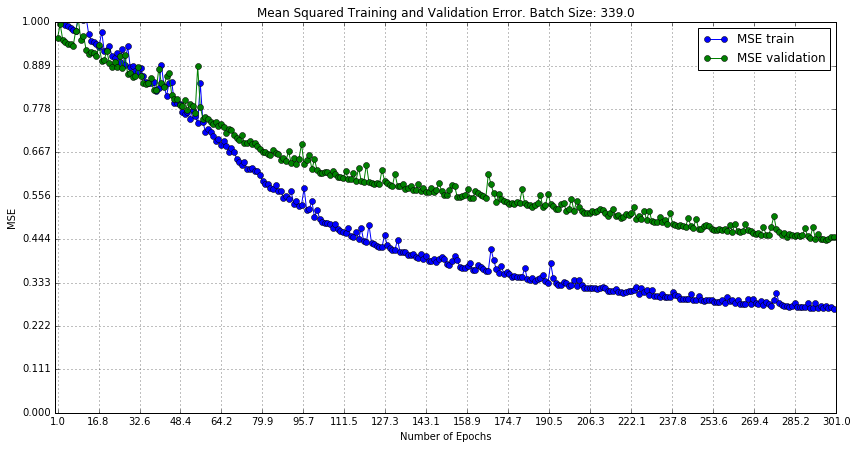

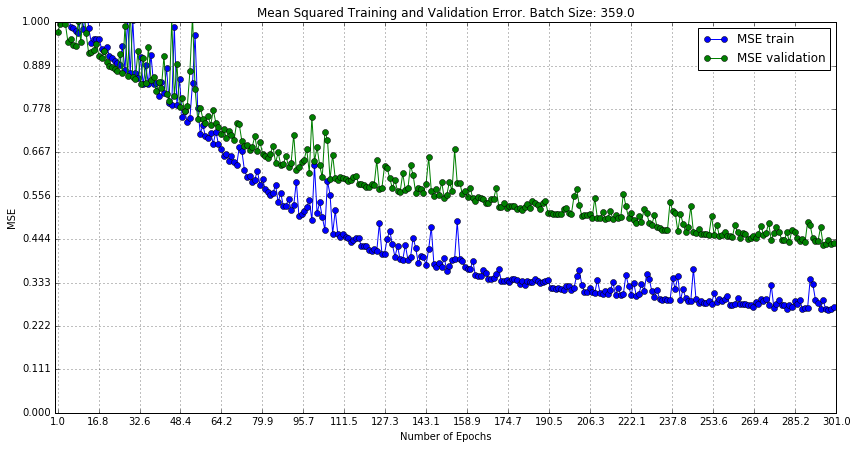

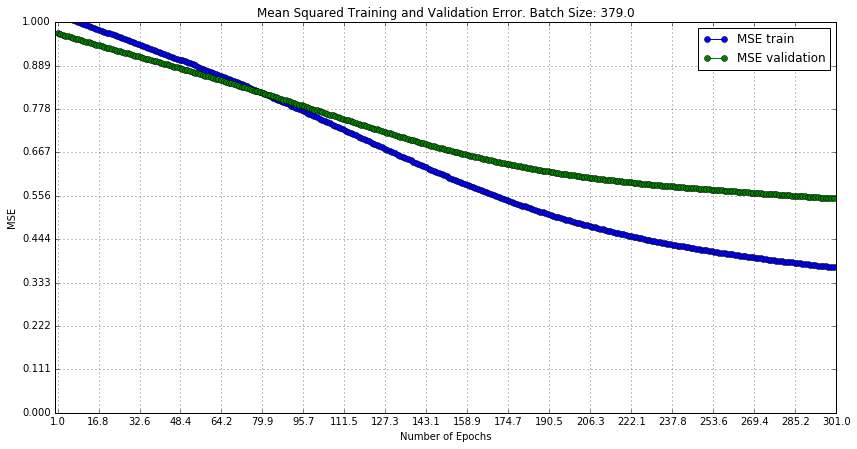

In [140]:
# making training and validation error plots
for i,hist in enumerate(hist_list):
    title = 'Mean Squared Training and Validation Error. Batch Size: {0}'.format(batch_sizes[i])
    history_plot(hist, title)

<div id='rec' />
## 3.-  Reconocimiento de imágenes en CIFAR10